# 📊 Análisis de Clientes - esBarre

Este notebook analiza la base de datos de visitas detalladas para:
1. Entender la estructura de los datos
2. Identificar clientes nuevos por mes
3. Identificar clientes que no han vuelto (churn mensual)


In [1]:
# Importar librerías
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)


## 1. Cargar y Explorar los Datos


In [2]:
# Cargar datos
with open('Detailed Visit Information.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(f"✅ Datos cargados: {len(df):,} registros")
print(f"\n📋 Columnas disponibles ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")


✅ Datos cargados: 42,280 registros

📋 Columnas disponibles (36):
   1. Categoria de Visita
   2. Email
   3. Esta Cancelada
   4. Esta Perdida
   5. Fecha de Visita
   6. Fecha y Hora de Creacion UTC
   7. ID de Ubicacion
   8. ID de la Clase
   9. ID del Cliente
  10. ID del Estudio
  11. ID del Grupo de Tipos
  12. ID del Tipo de Visita
  13. Indicador de Servicios Adicionales
  14. Is Complimentary
  15. Is Staff Paid
  16. Most Recent Visit Date
  17. Nombre de la Clase
  18. Nombre de la Ubicacion
  19. Nombre del Cliente
  20. Nombre del Sitio
  21. Numero de Referencia de la Visita
  22. Payment Method Ids
  23. Payment Method Names
  24. Pmtrefno
  25. Pricing Option
  26. Primera Reserva
  27. Registrado
  28. Reserva Online
  29. Tipo de Visita
  30. Trainer Full Name
  31. Trainer Id
  32. Visit Service Category Name
  33. Visitas Totales
  34. Visits Remaining on Pricing Option
  35. Reserva de Hitos
  36. Visit Room


In [4]:
# Ver primeras filas
display(df.head(3))

# Convertir fechas usando format='mixed' para manejar formatos inconsistentes
df['Fecha de Visita'] = pd.to_datetime(df['Fecha de Visita'], format='mixed')
df['Fecha y Hora de Creacion UTC'] = pd.to_datetime(df['Fecha y Hora de Creacion UTC'], format='mixed')
df['Most Recent Visit Date'] = pd.to_datetime(df['Most Recent Visit Date'], format='mixed')

# Crear columnas adicionales
df['Año'] = df['Fecha de Visita'].dt.year
df['Mes'] = df['Fecha de Visita'].dt.month
df['Año-Mes'] = df['Fecha de Visita'].dt.to_period('M')
df['Mes_Nombre'] = df['Fecha de Visita'].dt.strftime('%Y-%m')

# Excluir datos de diciembre 2025
df = df[~((df['Año'] == 2025) & (df['Mes'] == 12))]

print("✅ Fechas convertidas y columnas adicionales creadas")
print("✅ Datos de diciembre 2025 excluidos")
print(f"\n📅 Rango de fechas: {df['Fecha de Visita'].min().date()} a {df['Fecha de Visita'].max().date()}")



,Categoria de Visita,Email,Esta Cancelada,Esta Perdida,Fecha de Visita,Fecha y Hora de Creacion UTC,ID de Ubicacion,ID de la Clase,ID del Cliente,ID del Estudio,ID del Grupo de Tipos,ID del Tipo de Visita,Indicador de Servicios Adicionales,Is Complimentary,Is Staff Paid,Most Recent Visit Date,Nombre de la Clase,Nombre de la Ubicacion,Nombre del Cliente,Nombre del Sitio,Numero de Referencia de la Visita,Payment Method Ids,Payment Method Names,Pmtrefno,Pricing Option,Primera Reserva,Registrado,Reserva Online,Tipo de Visita,Trainer Full Name,Trainer Id,Visit Service Category Name,Visitas Totales,Visits Remaining on Pricing Option,Reserva de Hitos,Visit Room,Año,Mes,Año-Mes,Mes_Nombre
195,CLASS,vidal.yara@gmail.com,0,0,2025-11-30,2025-11-26 22:36:18.600,2,654,100012099,5738675,23,47,Non-Add On,0,1,2025-11-30,esPause,Trafalgar - esBarré,Yarq Vidal,esBarre,79398,801,Apple Pay,52339,1 Clase,1,1.0,True,Barre,Adriana Ramos,100000031,Bonos,42280,0,NaN,NaN,2025,11,2025-11,2025-11
196,CLASS,alessandra.miglio@gmail.com,0,0,2025-11-30,2025-11-24 22:38:05.000,2,655,100010887,5738675,23,47,Non-Add On,0,1,2025-11-30,esPause,Trafalgar - esBarré,Alessandra Miglio,esBarre,78827,9,Otro,47760,DESCUENTO 50% BONO 5 TRAFALGAR,0,1.0,True,Barre,Adriana Ramos,100000031,Bonos,42280,1,NaN,NaN,2025,11,2025-11,2025-11
197,CLASS,iria.villamarin@gmail.com,0,0,2025-11-30,2025-11-24 16:34:53.000,2,655,100004208,5738675,23,47,Non-Add On,1,1,2025-11-30,esPause,Trafalgar - esBarré,Iria Eiriz,esBarre,78680,7,Cortesía/Invitado,15783,Gympass,0,1.0,False,Barre,Adriana Ramos,100000031,Bonos,42280,0,NaN,NaN,2025,11,2025-11,2025-11


✅ Fechas convertidas y columnas adicionales creadas
✅ Datos de diciembre 2025 excluidos

📅 Rango de fechas: 2024-09-11 a 2025-11-30


## 2. Resumen General de la Base de Datos


In [5]:
print("="*60)
print("📊 RESUMEN GENERAL")
print("="*60)
print(f"\n🔢 Totales:")
print(f"   Total de visitas: {len(df):,}")
print(f"   Clientes únicos: {df['ID del Cliente'].nunique():,}")
print(f"   Clases diferentes: {df['ID de la Clase'].nunique():,}")
print(f"   Trainers: {df['Trainer Full Name'].nunique():,}")



# Categorización de Pricing Options
clase_suelta = ['1 Clase', '1 Clase ']
gympass = ['Gympass']
bonos = [
    'Bono Mensual 12 Clases', 
    'Bono Mensual 8 Clases', 
    'Bono Mensual 5 Clases', 
    'Bono Mensual Ilimitado',
    'Bono 3 Clases',
    'Unpaid Bonos'
]
classpass = ['ClassPass']
invitaciones = [
    '1 Clase Invitacion', 
    '1 Clase Invitacion ',
    'Unpaid Family&Friends - Pre-Open',
    'Clase de Cortesía',
    'CLASE PRUEBA TRAFALGAR',
    'Friends & Family'
]

descuentos = [
        'DESCUENTO 50% BONO 5 TRAFALGAR',
    'DESCUENTO 50% BONO 8 TRAFALGAR'
]
villapadierna = [
    'Villapadierna ilimitado',
    'Unpaid Villa Padierna x esBarré',
    'Villa Padierna Ilimitado'
]

# Crear nueva columna tipo_reserva
def categorizar_pricing_option(pricing_option):
    if pricing_option in clase_suelta:
        return 'Clase Suelta'
    elif pricing_option in gympass:
        return 'Gympass'
    elif pricing_option in bonos:
        return 'Bonos'
    elif pricing_option in classpass:
        return 'ClassPass'
    elif pricing_option in invitaciones:
        return 'Invitaciones'
    elif pricing_option in villapadierna:
        return 'Villa Padierna'
    elif pricing_option in descuentos   :
        return 'Descuentos'
    else:
        return 'Otros'

df['tipo_reserva'] = df['Pricing Option'].apply(categorizar_pricing_option)

df = df[df.tipo_reserva!='Villa Padierna']

print(f"\n🏢 Por Ubicación:")
for loc, count in df['Nombre de la Ubicacion'].value_counts().items():
    clientes_loc = df[df['Nombre de la Ubicacion'] == loc]['ID del Cliente'].nunique()
    print(f"   {loc}: {count:,} visitas | {clientes_loc:,} clientes")

print(f"\n🏋️ Qué clases dan:")
for clase, count in df['Nombre de la Clase'].value_counts().items():
    print(f"   {clase}: {count:,} visitas")


print(f"\n💳 Por donde reservan:")
for option, count in df['tipo_reserva'].value_counts().items():
    pct = count/len(df)*100
    print(f"   {option}: {count:,} ({pct:.1f}%)")


📊 RESUMEN GENERAL

🔢 Totales:
   Total de visitas: 42,085
   Clientes únicos: 8,984
   Clases diferentes: 577
   Trainers: 17

🏢 Por Ubicación:
   López de Hoyos - esBarre: 39,096 visitas | 7,970 clientes
   Trafalgar - esBarré: 2,961 visitas | 1,381 clientes

🏋️ Qué clases dan:
   esPlay: 21,305 visitas
   esPause: 20,501 visitas
   Friends & Family: 195 visitas
   Villa Padierna, Marbella: 56 visitas

💳 Por donde reservan:
   Bonos: 14,590 (34.7%)
   Gympass: 12,366 (29.4%)
   ClassPass: 11,475 (27.3%)
   Clase Suelta: 1,887 (4.5%)
   Invitaciones: 883 (2.1%)
   Descuentos: 856 (2.0%)


## 3. 🆕 Análisis de Clientes Nuevos por Mes



📊 CLIENTES NUEVOS POR TIPO DE RESERVA Y LOCAL


Tipo Reserva Primera Visita,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass,Invitaciones,TOTAL
Ubicacion Primera Visita,,,,,,,
López de Hoyos - esBarre,391,1330,4589,0,1470,166,7946
Trafalgar - esBarré,20,63,238,32,133,544,1030
TOTAL,411,1393,4827,32,1603,710,8976



📍 TRAFALGAR - CLIENTES NUEVOS POR TIPO DE RESERVA Y MES

📊 Valores absolutos:


Tipo Reserva Primera Visita,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass,Invitaciones,TOTAL
Mes_Primera_Visita,,,,,,,
2025-10,4,0,11,9,24,357,405
2025-11,16,63,227,23,109,187,625
TOTAL,20,63,238,32,133,544,1030



📊 Valores con porcentajes por mes:


Tipo Reserva Primera Visita,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass,Invitaciones
Mes_Primera_Visita,,,,,,
2025-10,4 (1.0%),0 (0.0%),11 (2.7%),9 (2.2%),24 (5.9%),357 (88.1%)
2025-11,16 (2.6%),63 (10.1%),227 (36.3%),23 (3.7%),109 (17.4%),187 (29.9%)



📍 LÓPEZ DE HOYOS - EVOLUCIÓN DE CLIENTES NUEVOS POR TIPO DE RESERVA


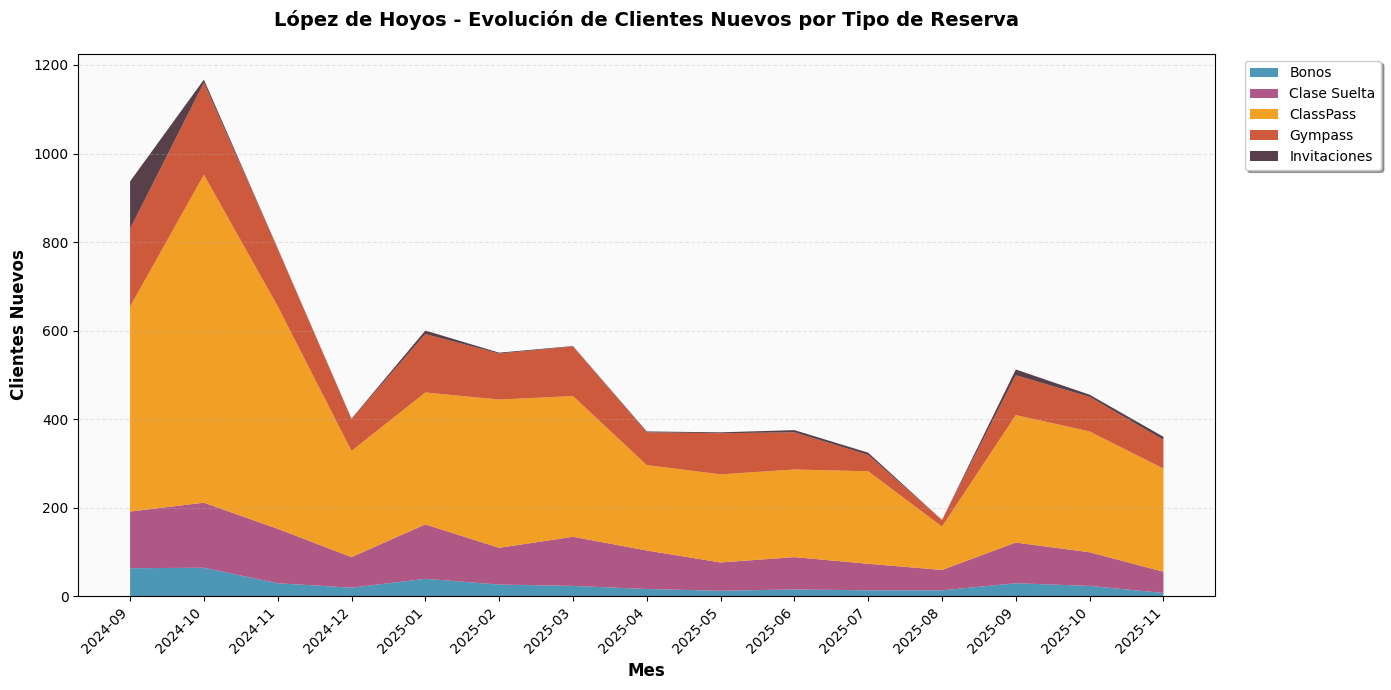


📍 LÓPEZ DE HOYOS - EVOLUCIÓN NORMALIZADA (Base = Primer Mes)

📊 Tabla normalizada (primer mes = 1.0):


Tipo Reserva Primera Visita,Bonos,Clase Suelta,ClassPass,Gympass,Invitaciones
Mes_Primera_Visita,,,,,
2024-09,1.00,1.00,1.00,1.00,1.00
2024-10,1.02,1.15,1.60,1.18,0.07
2024-11,0.46,0.96,1.09,0.74,0.01
2024-12,0.30,0.54,0.52,0.41,0.01
2025-01,0.62,0.96,0.64,0.75,0.07
2025-02,0.41,0.65,0.72,0.59,0.02
2025-03,0.37,0.87,0.69,0.64,0.01
2025-04,0.25,0.68,0.42,0.42,0.02
2025-05,0.19,0.50,0.43,0.53,0.02


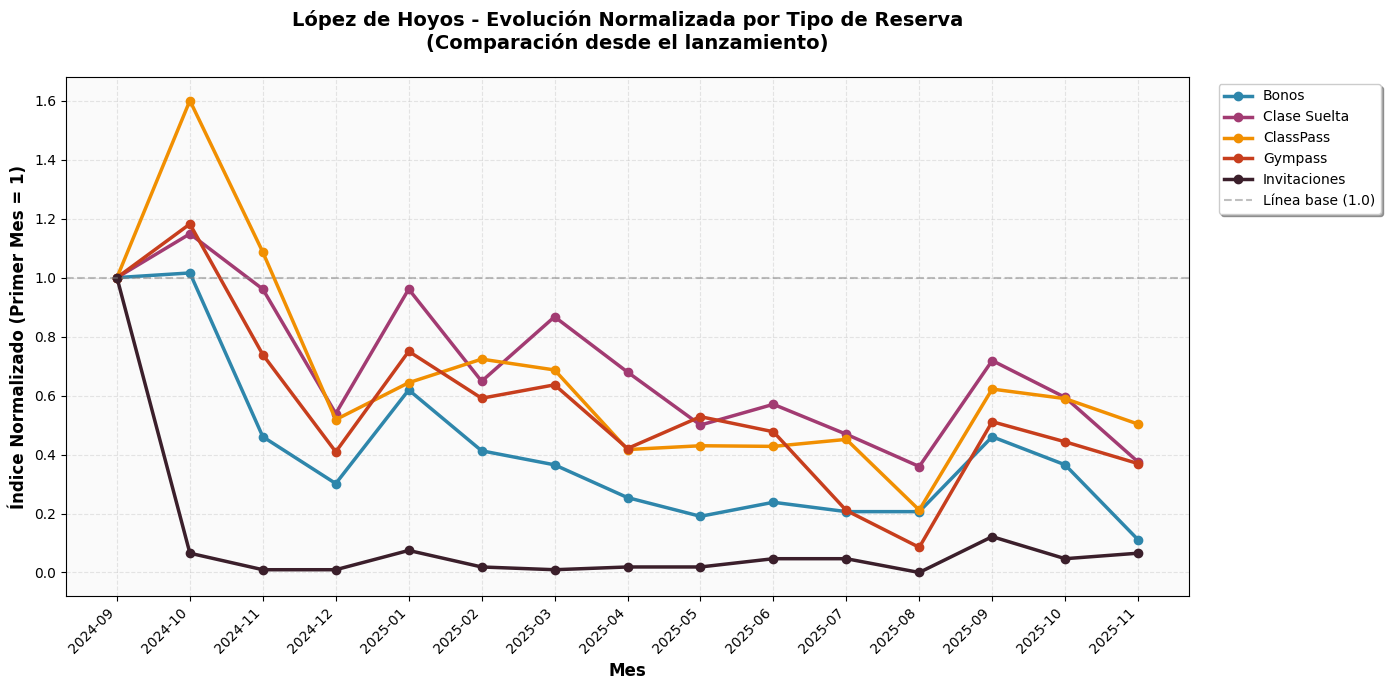

In [6]:
# Encontrar la primera visita de cada cliente con su ubicación
primera_visita_cliente = df.sort_values('Fecha de Visita').groupby('ID del Cliente').first().reset_index()
primera_visita_cliente = primera_visita_cliente[['ID del Cliente', 'Fecha de Visita', 'Nombre de la Ubicacion', 'tipo_reserva']]
primera_visita_cliente.columns = ['ID del Cliente', 'Primera Visita', 'Ubicacion Primera Visita', 'Tipo Reserva Primera Visita']
primera_visita_cliente['Mes_Primera_Visita'] = primera_visita_cliente['Primera Visita'].dt.to_period('M')

import matplotlib.pyplot as plt

# =============================================================================
# 1. TABLA: Nuevos clientes por tipo de reserva y local
# =============================================================================
print("\n" + "="*70)
print("📊 CLIENTES NUEVOS POR TIPO DE RESERVA Y LOCAL")
print("="*70)

tabla_por_local = primera_visita_cliente.groupby(['Ubicacion Primera Visita', 'Tipo Reserva Primera Visita']).size().unstack(fill_value=0)
tabla_por_local['TOTAL'] = tabla_por_local.sum(axis=1)
tabla_por_local.loc['TOTAL'] = tabla_por_local.sum()
display(tabla_por_local)

# =============================================================================
# 2. TABLA TRAFALGAR: Valores absolutos y % sobre fila
# =============================================================================
print("\n" + "="*70)
print("📍 TRAFALGAR - CLIENTES NUEVOS POR TIPO DE RESERVA Y MES")
print("="*70)

# Filtrar solo Trafalgar
trafalgar_data = primera_visita_cliente[primera_visita_cliente['Ubicacion Primera Visita'] == 'Trafalgar - esBarré']
tabla_trafalgar = trafalgar_data.groupby(['Mes_Primera_Visita', 'Tipo Reserva Primera Visita']).size().unstack(fill_value=0)
tabla_trafalgar.index = tabla_trafalgar.index.astype(str)

# Calcular porcentajes por fila
tabla_trafalgar_pct = tabla_trafalgar.div(tabla_trafalgar.sum(axis=1), axis=0) * 100

# Crear tabla combinada con valores absolutos y porcentajes
tabla_trafalgar_combinada = tabla_trafalgar.copy().astype(str)
for col in tabla_trafalgar.columns:
    tabla_trafalgar_combinada[col] = tabla_trafalgar[col].astype(str) + ' (' + tabla_trafalgar_pct[col].round(1).astype(str) + '%)'

# Agregar columna de total
tabla_trafalgar['TOTAL'] = tabla_trafalgar.sum(axis=1)
tabla_trafalgar.loc['TOTAL'] = tabla_trafalgar.sum()

print("\n📊 Valores absolutos:")
display(tabla_trafalgar)

print("\n📊 Valores con porcentajes por mes:")
display(tabla_trafalgar_combinada)

# =============================================================================
# 3. GRÁFICA STACKED AREA: Evolución clientes nuevos por tipo (LÓPEZ DE HOYOS)
# =============================================================================
print("\n" + "="*70)
print("📍 LÓPEZ DE HOYOS - EVOLUCIÓN DE CLIENTES NUEVOS POR TIPO DE RESERVA")
print("="*70)

# Filtrar solo López de Hoyos
lopez_data = primera_visita_cliente[primera_visita_cliente['Ubicacion Primera Visita'] == 'López de Hoyos - esBarre']
tabla_evolucion = lopez_data.groupby(['Mes_Primera_Visita', 'Tipo Reserva Primera Visita']).size().unstack(fill_value=0)
tabla_evolucion.index = tabla_evolucion.index.astype(str)

# Colores elegantes
colores = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623', '#5C4D7D']

fig, ax = plt.subplots(figsize=(14, 7))
ax.stackplot(tabla_evolucion.index, tabla_evolucion.T.values, 
             labels=tabla_evolucion.columns, colors=colores[:len(tabla_evolucion.columns)], alpha=0.85)

ax.set_xlabel('Mes', fontsize=12, fontweight='bold')
ax.set_ylabel('Clientes Nuevos', fontsize=12, fontweight='bold')
ax.set_title('López de Hoyos - Evolución de Clientes Nuevos por Tipo de Reserva', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, fancybox=True, shadow=True)
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_facecolor('#fafafa')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

# =============================================================================
# 4. GRÁFICA NORMALIZADA: Evolución relativa desde lanzamiento (LÓPEZ DE HOYOS)
# =============================================================================
print("\n" + "="*70)
print("📍 LÓPEZ DE HOYOS - EVOLUCIÓN NORMALIZADA (Base = Primer Mes)")
print("="*70)

# Normalizar: dividir cada columna por su primer valor (mes de lanzamiento = 1)
tabla_normalizada = tabla_evolucion.copy()
for col in tabla_normalizada.columns:
    primer_valor = tabla_normalizada[col].iloc[0]
    if primer_valor > 0:
        tabla_normalizada[col] = tabla_normalizada[col] / primer_valor
    else:
        # Si el primer valor es 0, buscar el primer valor no cero
        primer_no_cero = tabla_normalizada[col][tabla_normalizada[col] > 0].iloc[0] if (tabla_normalizada[col] > 0).any() else 1
        tabla_normalizada[col] = tabla_normalizada[col] / primer_no_cero

print("\n📊 Tabla normalizada (primer mes = 1.0):")
display(tabla_normalizada.round(2))

fig, ax = plt.subplots(figsize=(14, 7))

for i, col in enumerate(tabla_normalizada.columns):
    ax.plot(tabla_normalizada.index, tabla_normalizada[col], 
            marker='o', linewidth=2.5, markersize=6, 
            label=col, color=colores[i % len(colores)])

ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Línea base (1.0)')
ax.set_xlabel('Mes', fontsize=12, fontweight='bold')
ax.set_ylabel('Índice Normalizado (Primer Mes = 1)', fontsize=12, fontweight='bold')
ax.set_title('López de Hoyos - Evolución Normalizada por Tipo de Reserva\n(Comparación desde el lanzamiento)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, fancybox=True, shadow=True)
plt.xticks(rotation=45, ha='right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#fafafa')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

## 4. 📉 Análisis de Clientes que No Han Vuelto (Churn)


📅 Fecha de referencia (última visita en el sistema): 2025-11-30

📊 Estadísticas de inactividad:
   - Media días sin visita: 195.8
   - Mediana días sin visita: 191.0

📅 Mes actual: 2025-11
📅 Mes anterior: 2025-10

📉 ANÁLISIS DE CHURN (criterio: clientes que dejaron de venir y no han vuelto)
   Clientes totales: 8,976
   Clientes activos (última visita en 2025-11): 1,912 (21.3%)
   Clientes churn (no han vuelto desde su última visita): 7,064 (78.7%)
   Clientes cuya última visita fue en 2025-10 (churn reciente): 866

📊 DESGLOSE DE CLIENTES CHURN POR NÚMERO DE VISITAS:
   Vinieron 1 sola vez y no volvieron: 4,634 (65.6%)
   Vinieron más de 1 vez pero dejaron de venir: 2,430 (34.4%)
   Promedio de visitas antes de abandonar: 3.4

📍 ANÁLISIS POR LOCAL:

Trafalgar - esBarré:
   Clientes totales: 1,298
   Clientes activos (última visita en 2025-11): 988 (76.1%)
   Clientes churn: 310 (23.9%)

López de Hoyos - esBarre:
   Clientes totales: 7,678
   Clientes activos (última visita en 2025-11):

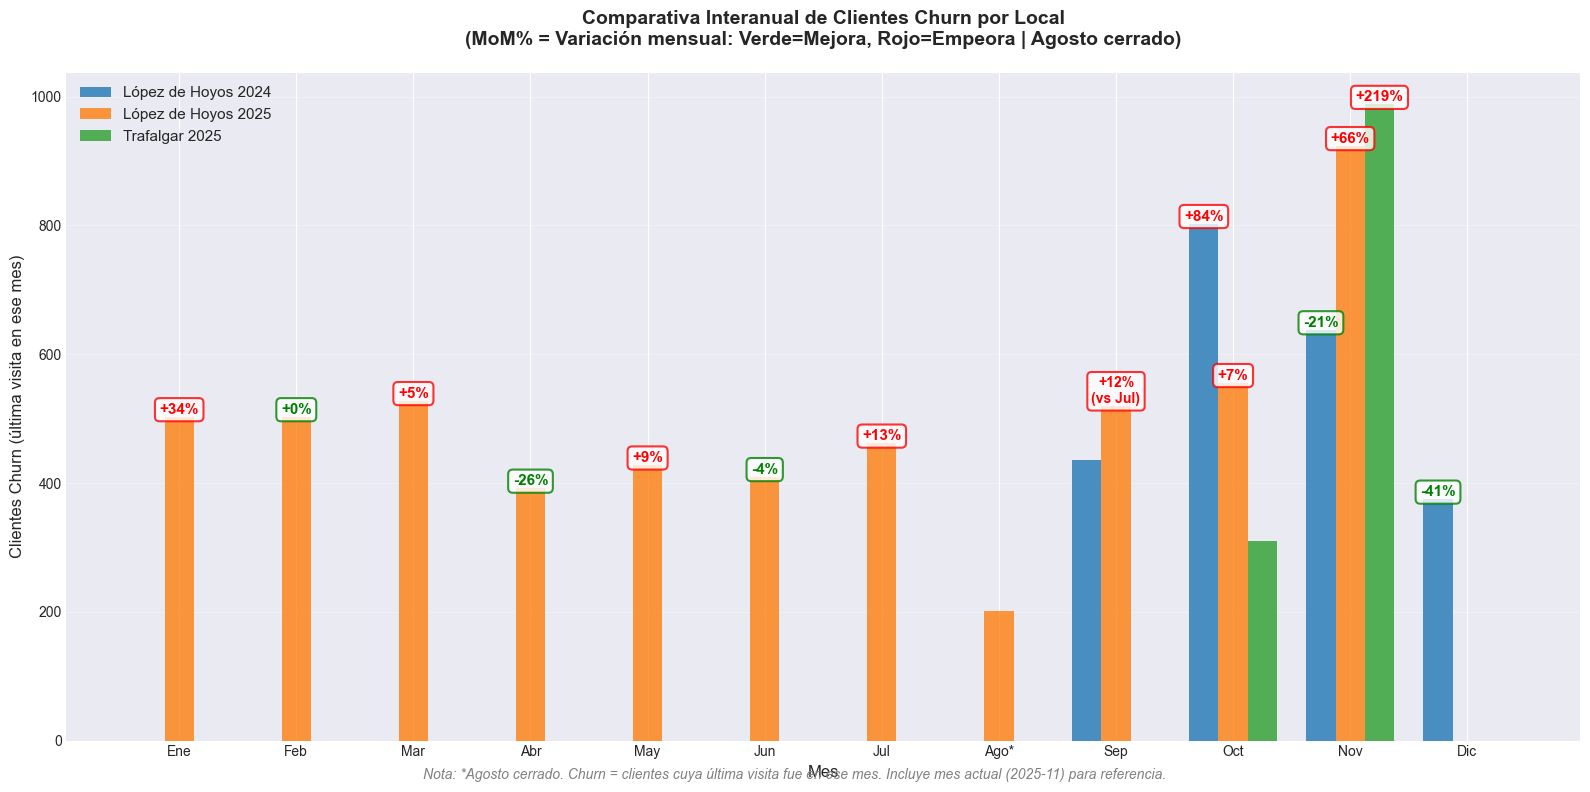


📊 WATERFALL CHART: Balance de Clientes por Local (Nuevos vs Churn)

📍 Trafalgar - esBarré
    Mes  Clientes Nuevos  Clientes Churn  Balance Neto  Total Clientes
2025-10              539             310           229             229
2025-11              842             988          -146              83


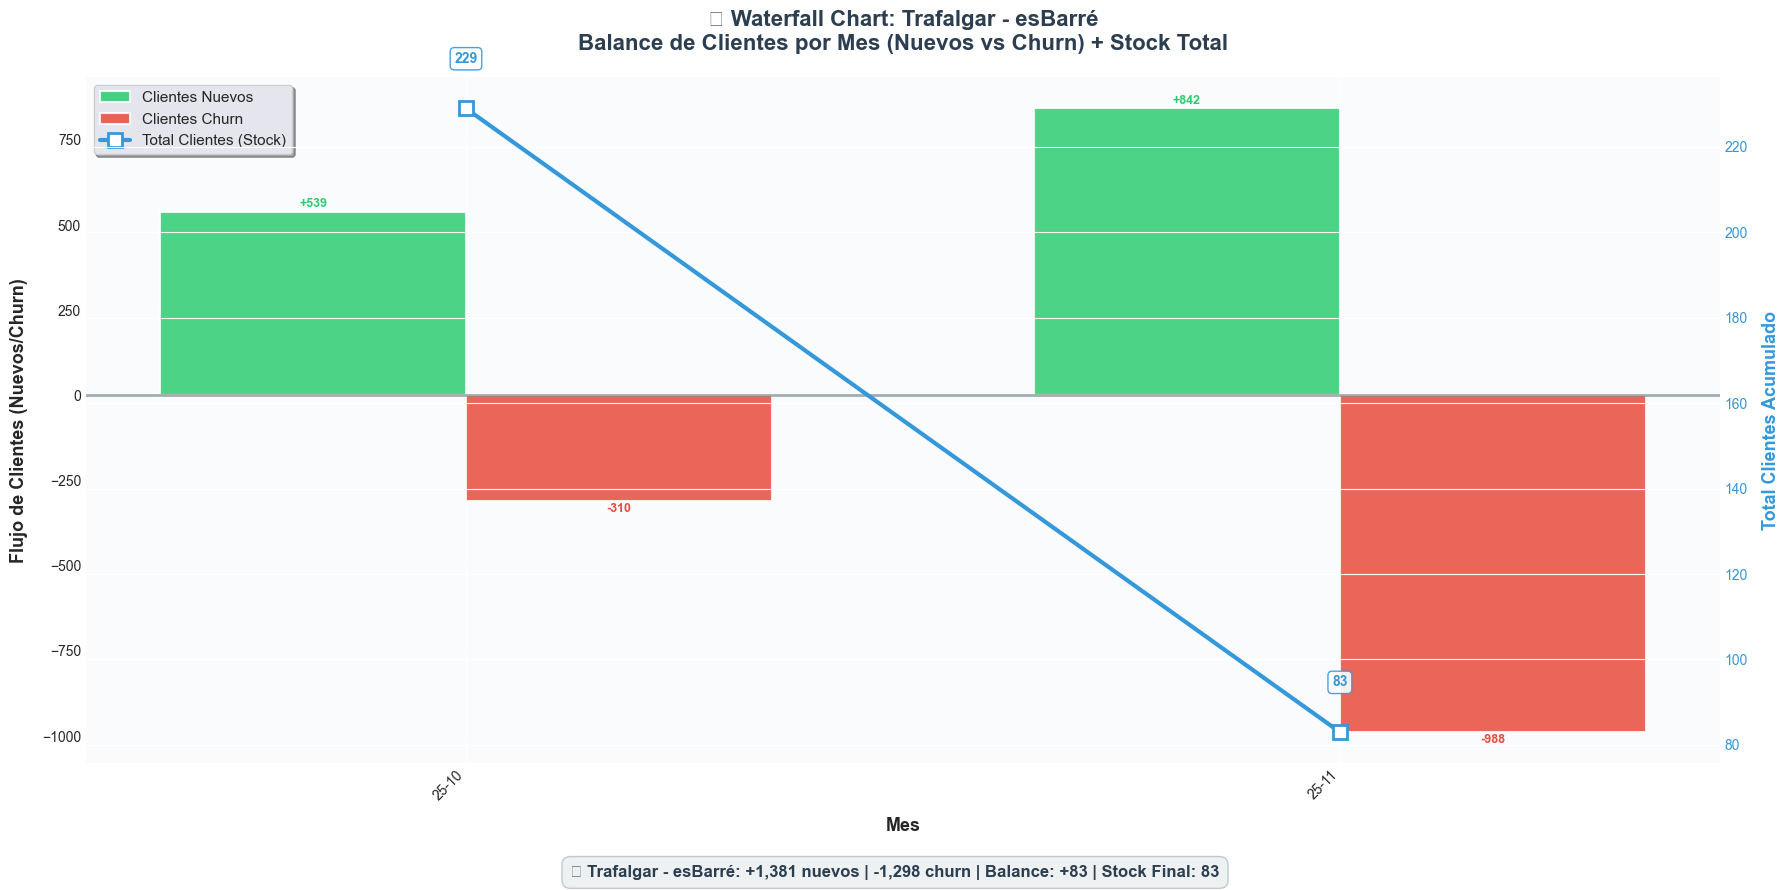


📍 López de Hoyos - esBarre
    Mes  Clientes Nuevos  Clientes Churn  Balance Neto  Total Clientes
2024-09              937             436           501             501
2024-10             1167             803           364             865
2024-11              786             638           148            1013
2024-12              401             375            26            1039
2025-01              600             503            97            1136
2025-02              550             503            47            1183
2025-03              565             528            37            1220
2025-04              372             392           -20            1200
2025-05              370             428           -58            1142
2025-06              375             410           -35            1107
2025-07              324             462          -138             969
2025-09              512             519            -7             933
2025-10              456             556         

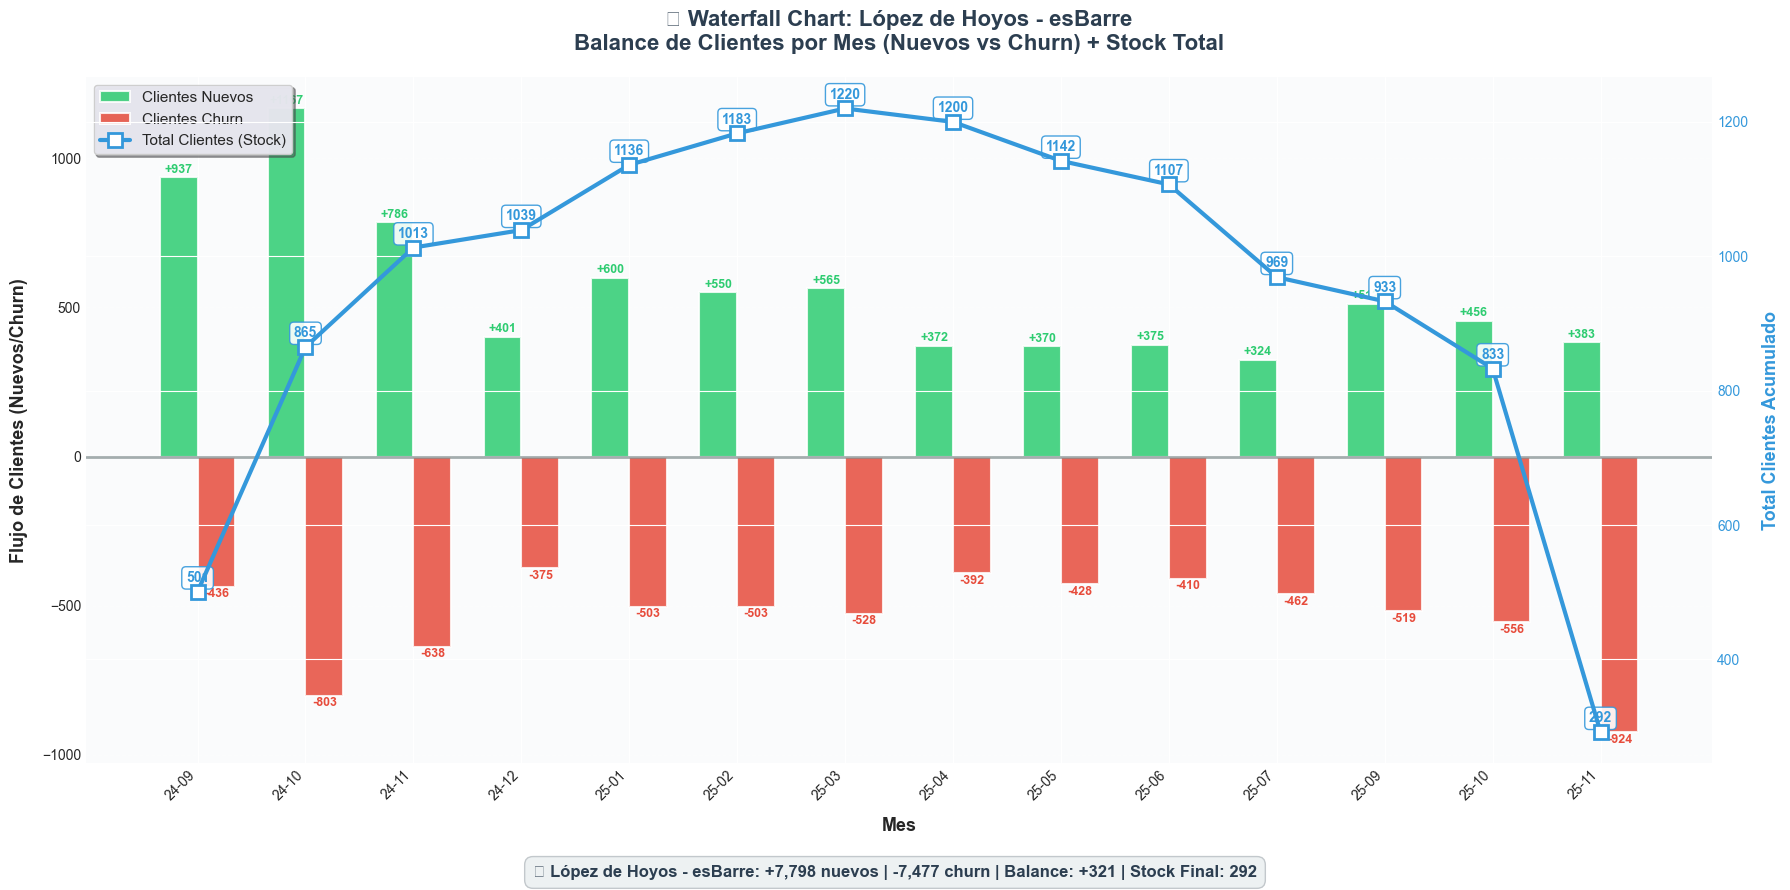


📊 STACKED AREA: Clientes Churn por Tipo de Reserva - LÓPEZ DE HOYOS

📊 López de Hoyos - Clientes churn por Tipo de Reserva y Mes:


Tipo Reserva Ultima,Bonos,Clase Suelta,ClassPass,Gympass,Invitaciones
Mes_Ultima_Visita,,,,,
2024-09,3,82,252,43,56
2024-10,70,99,535,91,8
2024-11,29,80,447,81,1
2024-12,33,52,237,52,1
2025-01,19,73,322,85,4
2025-02,40,60,334,69,0
2025-03,29,83,315,101,0
2025-04,39,67,208,77,1
2025-05,28,56,246,96,2


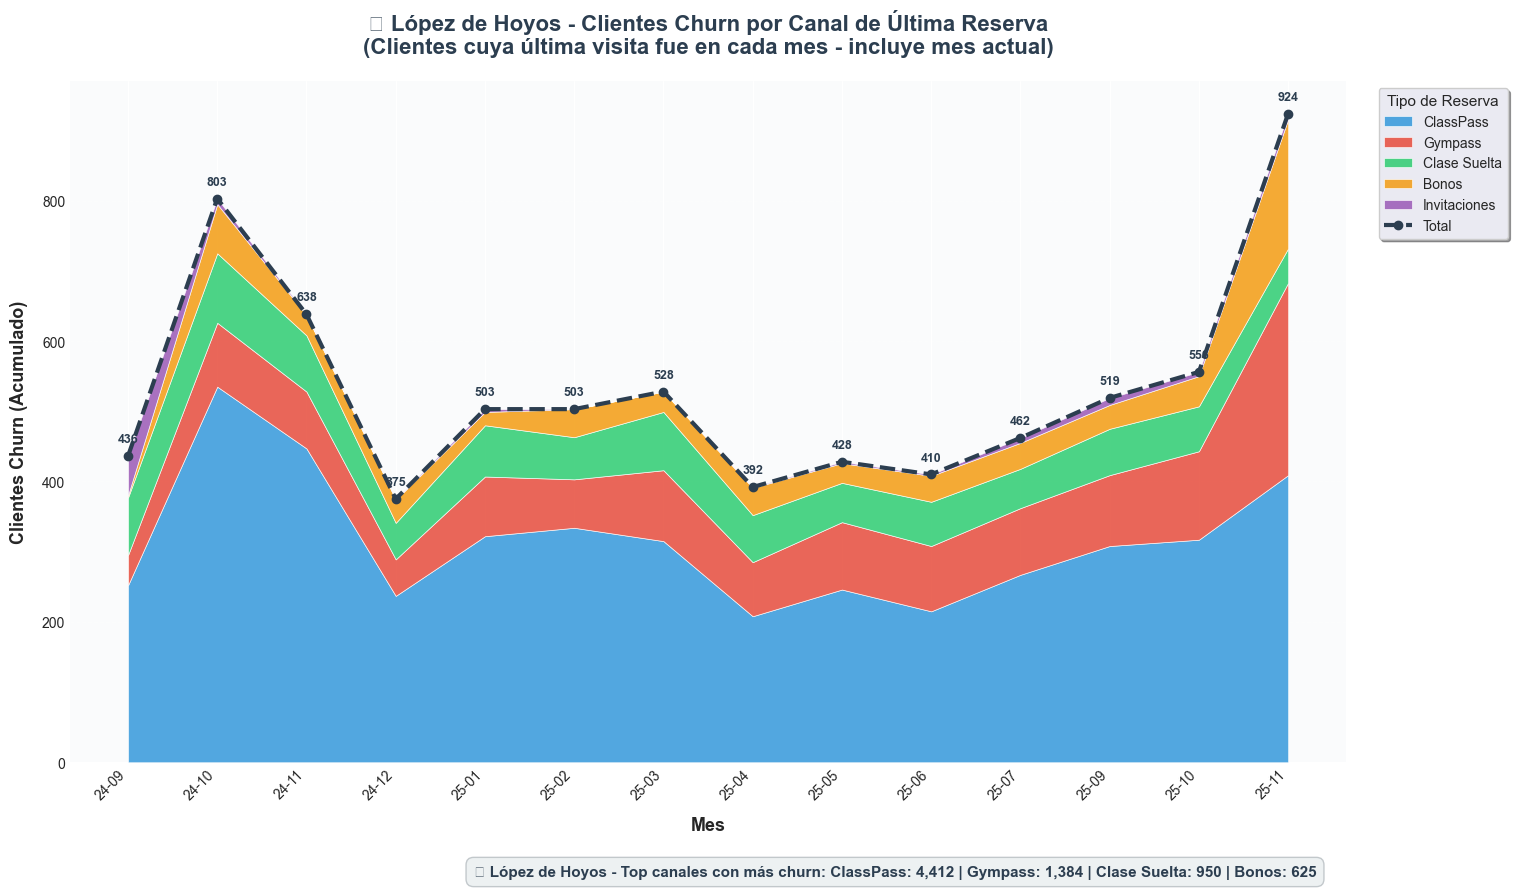


📊 RESUMEN LÓPEZ DE HOYOS: Clientes Churn por Canal de Última Reserva
   ClassPass:  4412 clientes (59.0%)
   Gympass:  1384 clientes (18.5%)
   Clase Suelta:   950 clientes (12.7%)
   Bonos:   625 clientes (8.4%)
   Invitaciones:   106 clientes (1.4%)

   Total López de Hoyos: 7,477 clientes churn

📊 TABLA: Clientes Churn por Tipo de Reserva - TRAFALGAR

📊 Trafalgar - Clientes churn por Tipo de Reserva y Mes:


Tipo Reserva Ultima,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass,Invitaciones
Mes_Ultima_Visita,,,,,,
2025-10,5,1,14,4,12,274
2025-11,60,63,293,179,227,166



📊 RESUMEN TRAFALGAR: Clientes Churn por Canal de Última Reserva
   Invitaciones:   440 clientes (33.9%)
   ClassPass:   307 clientes (23.7%)
   Gympass:   239 clientes (18.4%)
   Descuentos:   183 clientes (14.1%)
   Bonos:    65 clientes (5.0%)
   Clase Suelta:    64 clientes (4.9%)

   Total Trafalgar: 1,298 clientes churn


In [143]:
# Encontrar la última visita de cada cliente
ultima_visita_cliente = df.groupby('ID del Cliente').agg({
    'Fecha de Visita': ['min', 'max', 'count'],
    'Nombre del Cliente': 'first',
    'Email': 'first',
    'tipo_reserva': 'last'
}).reset_index()

ultima_visita_cliente.columns = ['ID del Cliente', 'Primera Visita', 'Ultima Visita', 
                                   'Total Visitas', 'Nombre', 'Email', 'Ultimo Tipo Reserva']

# Calcular días desde la última visita
fecha_actual = df['Fecha de Visita'].max()
ultima_visita_cliente['Dias_Sin_Visita'] = (fecha_actual - ultima_visita_cliente['Ultima Visita']).dt.days
ultima_visita_cliente['Mes_Ultima_Visita'] = ultima_visita_cliente['Ultima Visita'].dt.to_period('M')

print(f"📅 Fecha de referencia (última visita en el sistema): {fecha_actual.date()}")
print(f"\n📊 Estadísticas de inactividad:")
print(f"   - Media días sin visita: {ultima_visita_cliente['Dias_Sin_Visita'].mean():.1f}")
print(f"   - Mediana días sin visita: {ultima_visita_cliente['Dias_Sin_Visita'].median():.1f}")

# =============================================================================
# DEFINICIÓN DE CHURN: Clientes cuya última visita fue en un mes dado
# y nunca más volvieron en los meses siguientes
# =============================================================================

# Obtener el mes máximo del dataset y el mes anterior
mes_maximo = df['Fecha de Visita'].dt.to_period('M').max()
mes_anterior = mes_maximo - 1
print(f"\n📅 Mes actual: {mes_maximo}")
print(f"📅 Mes anterior: {mes_anterior}")

# Clientes churn: TODOS los clientes cuya última visita NO fue en el mes actual
# INCLUYENDO el mes actual para ver el churn más reciente
clientes_churn = ultima_visita_cliente.copy()  # Incluir todos para análisis
clientes_activos = ultima_visita_cliente[ultima_visita_cliente['Mes_Ultima_Visita'] == mes_maximo].copy()

# Churn del último mes: clientes que estuvieron activos el mes anterior pero no han venido este mes
clientes_mes_anterior = ultima_visita_cliente[ultima_visita_cliente['Mes_Ultima_Visita'] == mes_anterior].copy()
churn_ultimo_mes = len(clientes_mes_anterior)

print(f"\n📉 ANÁLISIS DE CHURN (criterio: clientes que dejaron de venir y no han vuelto)")
print("="*60)
print(f"   Clientes totales: {len(ultima_visita_cliente):,}")
print(f"   Clientes activos (última visita en {mes_maximo}): {len(clientes_activos):,} ({len(clientes_activos)/len(ultima_visita_cliente)*100:.1f}%)")
print(f"   Clientes churn (no han vuelto desde su última visita): {len(ultima_visita_cliente) - len(clientes_activos):,} ({(len(ultima_visita_cliente) - len(clientes_activos))/len(ultima_visita_cliente)*100:.1f}%)")
print(f"   Clientes cuya última visita fue en {mes_anterior} (churn reciente): {churn_ultimo_mes:,}")

# Desglose por número de visitas antes de abandonar
print(f"\n📊 DESGLOSE DE CLIENTES CHURN POR NÚMERO DE VISITAS:")
print("="*60)
clientes_churn_sin_activos = ultima_visita_cliente[ultima_visita_cliente['Mes_Ultima_Visita'] < mes_maximo].copy()
una_sola_visita = clientes_churn_sin_activos[clientes_churn_sin_activos['Total Visitas'] == 1]
multiples_visitas = clientes_churn_sin_activos[clientes_churn_sin_activos['Total Visitas'] > 1]
print(f"   Vinieron 1 sola vez y no volvieron: {len(una_sola_visita):,} ({len(una_sola_visita)/len(clientes_churn_sin_activos)*100:.1f}%)")
print(f"   Vinieron más de 1 vez pero dejaron de venir: {len(multiples_visitas):,} ({len(multiples_visitas)/len(clientes_churn_sin_activos)*100:.1f}%)")
print(f"   Promedio de visitas antes de abandonar: {clientes_churn_sin_activos['Total Visitas'].mean():.1f}")

# Obtener ubicación de última visita para cada cliente
ultima_ubicacion = df.loc[df.groupby('ID del Cliente')['Fecha de Visita'].idxmax()][['ID del Cliente', 'Nombre de la Ubicacion']]
ultima_ubicacion.columns = ['ID del Cliente', 'Ultima Ubicacion']
clientes_churn = clientes_churn.merge(ultima_ubicacion, on='ID del Cliente', how='left')
ultima_visita_cliente = ultima_visita_cliente.merge(ultima_ubicacion, on='ID del Cliente', how='left')

# Análisis por local
print(f"\n📍 ANÁLISIS POR LOCAL:")
print("="*60)
for local in ultima_visita_cliente['Ultima Ubicacion'].dropna().unique():
    clientes_local = ultima_visita_cliente[ultima_visita_cliente['Ultima Ubicacion'] == local]
    activos_local = clientes_local[clientes_local['Mes_Ultima_Visita'] == mes_maximo]
    churn_local = clientes_local[clientes_local['Mes_Ultima_Visita'] < mes_maximo]
    
    print(f"\n{local}:")
    print(f"   Clientes totales: {len(clientes_local):,}")
    print(f"   Clientes activos (última visita en {mes_maximo}): {len(activos_local):,} ({len(activos_local)/len(clientes_local)*100:.1f}%)")
    print(f"   Clientes churn: {len(churn_local):,} ({len(churn_local)/len(clientes_local)*100:.1f}%)")


# Clientes churn por mes de última visita y por local (INCLUYENDO MES ACTUAL)
churn_por_mes_local = clientes_churn.groupby(['Mes_Ultima_Visita', 'Ultima Ubicacion']).size().reset_index(name='Clientes Churn')
churn_por_mes_local['Mes_Ultima_Visita'] = churn_por_mes_local['Mes_Ultima_Visita'].astype(str)

print("\n📉 CLIENTES CHURN - Por Mes de Última Visita y Local")
print("="*60)
print("(Clientes cuya última visita fue en ese mes - incluye mes actual para referencia)\n")

# Crear tabla pivote para mejor visualización
churn_pivot = churn_por_mes_local.pivot(index='Mes_Ultima_Visita', 
                                         columns='Ultima Ubicacion', 
                                         values='Clientes Churn').fillna(0).astype(int)

print(churn_pivot)

print("\n📊 TOTALES POR LOCAL:")
print("="*60)
for local in churn_pivot.columns:
    total = churn_pivot[local].sum()
    print(f"   {local}: {total:>5} clientes churn")

print(f"\n   📊 Total clientes churn (todos los locales): {churn_por_mes_local['Clientes Churn'].sum():,}")

# Visualización comparativa interanual con barras agrupadas
import matplotlib.pyplot as plt
import numpy as np

# Preparar datos para visualización
churn_por_mes_local['Año'] = churn_por_mes_local['Mes_Ultima_Visita'].str[:4]
churn_por_mes_local['Mes'] = churn_por_mes_local['Mes_Ultima_Visita'].str[5:7].astype(int)

# Filtrar datos por local y año
lopez_2024 = churn_por_mes_local[(churn_por_mes_local['Ultima Ubicacion'] == 'López de Hoyos - esBarre') & 
                                  (churn_por_mes_local['Año'] == '2024')].set_index('Mes')['Clientes Churn']
lopez_2025 = churn_por_mes_local[(churn_por_mes_local['Ultima Ubicacion'] == 'López de Hoyos - esBarre') & 
                                  (churn_por_mes_local['Año'] == '2025')].set_index('Mes')['Clientes Churn']
trafalgar_2025 = churn_por_mes_local[(churn_por_mes_local['Ultima Ubicacion'] == 'Trafalgar - esBarré') & 
                                      (churn_por_mes_local['Año'] == '2025')].set_index('Mes')['Clientes Churn']

# Crear DataFrame completo con todos los meses
meses = np.arange(1, 13)
df_plot = pd.DataFrame({
    'López de Hoyos 2024': [lopez_2024.get(m, 0) for m in meses],
    'López de Hoyos 2025': [lopez_2025.get(m, 0) for m in meses],
    'Trafalgar 2025': [trafalgar_2025.get(m, 0) for m in meses]
}, index=meses)

# Crear gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(meses))
width = 0.25

bars1 = ax.bar(x - width, df_plot['López de Hoyos 2024'], width, 
               label='López de Hoyos 2024', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, df_plot['López de Hoyos 2025'], width, 
               label='López de Hoyos 2025', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, df_plot['Trafalgar 2025'], width, 
               label='Trafalgar 2025', color='#2ca02c', alpha=0.8)

# Añadir MoM% encima de cada barra (más grande y visible)
# NOTA: Agosto cerrado - comparar septiembre con julio
for i, (bars, col) in enumerate([(bars1, 'López de Hoyos 2024'), 
                                   (bars2, 'López de Hoyos 2025'), 
                                   (bars3, 'Trafalgar 2025')]):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        mes_actual = j + 1  # Mes 1-12
        
        # Ignorar agosto (mes 8) - no mostrar MoM
        if mes_actual == 8:
            continue
        
        # Para López de Hoyos 2025, comparar enero con diciembre 2024
        if col == 'López de Hoyos 2025' and mes_actual == 1:  # Enero 2025
            valor_anterior = df_plot['López de Hoyos 2024'].iloc[11]  # Diciembre 2024
            if valor_anterior > 0 and height > 0:
                mom_pct = ((height - valor_anterior) / valor_anterior) * 100
                color_texto = 'red' if mom_pct > 0 else 'green'
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{mom_pct:+.0f}%',
                       ha='center', va='bottom', fontsize=11, 
                       color=color_texto, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                edgecolor=color_texto, alpha=0.8, linewidth=1.5))
        # Septiembre (mes 9) compara con julio (mes 7) porque agosto cerrado
        elif mes_actual == 9 and height > 0:
            valor_anterior = df_plot[col].iloc[6]  # Julio (índice 6)
            if valor_anterior > 0:
                mom_pct = ((height - valor_anterior) / valor_anterior) * 100
                color_texto = 'red' if mom_pct > 0 else 'green'
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{mom_pct:+.0f}%\n(vs Jul)',
                       ha='center', va='bottom', fontsize=10, 
                       color=color_texto, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                edgecolor=color_texto, alpha=0.8, linewidth=1.5))
        # Para el resto de meses, comparar con el mes anterior del mismo año
        elif height > 0 and j > 0:
            valor_anterior = df_plot[col].iloc[j-1]
            if valor_anterior > 0:
                mom_pct = ((height - valor_anterior) / valor_anterior) * 100
                color_texto = 'red' if mom_pct > 0 else 'green'
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{mom_pct:+.0f}%',
                       ha='center', va='bottom', fontsize=11, 
                       color=color_texto, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                edgecolor=color_texto, alpha=0.8, linewidth=1.5))

ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Clientes Churn (última visita en ese mes)', fontsize=12)
ax.set_title('Comparativa Interanual de Clientes Churn por Local\n(MoM% = Variación mensual: Verde=Mejora, Rojo=Empeora | Agosto cerrado)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                    'Jul', 'Ago*', 'Sep', 'Oct', 'Nov', 'Dic'])
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Añadir nota explicativa
fig.text(0.5, 0.02, f'Nota: *Agosto cerrado. Churn = clientes cuya última visita fue en ese mes. Incluye mes actual ({mes_maximo}) para referencia.',
         ha='center', fontsize=10, style='italic', color='gray')

plt.tight_layout()
plt.show()

# =============================================================================
# WATERFALL CHART: Balance Clientes Nuevos vs Churn - POR LOCAL
# =============================================================================
print("\n" + "="*70)
print("📊 WATERFALL CHART: Balance de Clientes por Local (Nuevos vs Churn)")
print("="*70)

# Obtener lista de locales
locales = df['Nombre de la Ubicacion'].unique()

for local in locales:
    print(f"\n{'='*70}")
    print(f"📍 {local}")
    print("="*70)
    
    # Filtrar datos del local
    df_local = df[df['Nombre de la Ubicacion'] == local].copy()
    
    # Preparar datos de clientes nuevos por mes para este local
    clientes_nuevos_local = df_local.groupby('ID del Cliente')['Fecha de Visita'].min().reset_index()
    clientes_nuevos_local['Mes_Primera_Visita'] = clientes_nuevos_local['Fecha de Visita'].dt.to_period('M').astype(str)
    nuevos_por_mes_local = clientes_nuevos_local.groupby('Mes_Primera_Visita').size().reset_index(name='Clientes Nuevos')
    
    # Preparar datos de churn por mes para este local (excluyendo mes actual para churn real)
    churn_local = clientes_churn[(clientes_churn['Ultima Ubicacion'] == local) ].copy()
    churn_por_mes_local_wf = churn_local.groupby('Mes_Ultima_Visita').size().reset_index(name='Clientes Churn')
    churn_por_mes_local_wf['Mes_Ultima_Visita'] = churn_por_mes_local_wf['Mes_Ultima_Visita'].astype(str)
    
    # Merge de datos
    waterfall_data = nuevos_por_mes_local.merge(churn_por_mes_local_wf, 
                                                 left_on='Mes_Primera_Visita', 
                                                 right_on='Mes_Ultima_Visita', 
                                                 how='outer').fillna(0)
    waterfall_data['Mes'] = waterfall_data['Mes_Primera_Visita'].combine_first(waterfall_data['Mes_Ultima_Visita'])
    waterfall_data = waterfall_data[['Mes', 'Clientes Nuevos', 'Clientes Churn']].sort_values('Mes')
    waterfall_data['Clientes Nuevos'] = waterfall_data['Clientes Nuevos'].astype(int)
    waterfall_data['Clientes Churn'] = waterfall_data['Clientes Churn'].astype(int)
    waterfall_data['Balance Neto'] = waterfall_data['Clientes Nuevos'] - waterfall_data['Clientes Churn']
    
    # Calcular stock acumulado de clientes
    waterfall_data['Total Clientes'] = waterfall_data['Balance Neto'].cumsum()
    
    # Excluir agosto del análisis
    waterfall_data = waterfall_data[~waterfall_data['Mes'].str.contains('2024-08|2025-08')]
    
    print(waterfall_data.to_string(index=False))
    
    # Crear Waterfall Chart moderno
    fig, ax = plt.subplots(figsize=(18, 9))
    
    meses_wf = waterfall_data['Mes'].tolist()
    nuevos = waterfall_data['Clientes Nuevos'].tolist()
    churn_vals = waterfall_data['Clientes Churn'].tolist()
    balance = waterfall_data['Balance Neto'].tolist()
    total_clientes = waterfall_data['Total Clientes'].tolist()
    
    x = np.arange(len(meses_wf))
    width = 0.35
    
    # Colores elegantes
    color_nuevos = '#2ecc71'  # Verde esmeralda
    color_churn = '#e74c3c'  # Rojo coral
    color_balance_pos = '#27ae60'  # Verde oscuro
    color_balance_neg = '#c0392b'  # Rojo oscuro
    color_stock = '#3498db'  # Azul para stock
    
    # Barras de clientes nuevos (positivas)
    bars_nuevos = ax.bar(x - width/2, nuevos, width, label='Clientes Nuevos', 
                          color=color_nuevos, alpha=0.85, edgecolor='white', linewidth=1.5)
    
    # Barras de clientes churn (negativas)
    bars_churn = ax.bar(x + width/2, [-c for c in churn_vals], width, label='Clientes Churn', 
                         color=color_churn, alpha=0.85, edgecolor='white', linewidth=1.5)
    
    # Crear segundo eje Y para el stock de clientes
    ax2 = ax.twinx()
    
    # Línea de stock total de clientes
    line_stock = ax2.plot(x, total_clientes, color=color_stock, linewidth=3, marker='s', markersize=10, 
                          label='Total Clientes (Stock)', zorder=5, markerfacecolor='white', markeredgewidth=2)
    
    # Añadir valores en las barras
    for i, (n, c, b, t) in enumerate(zip(nuevos, churn_vals, balance, total_clientes)):
        # Valor nuevos
        ax.text(x[i] - width/2, n + 5, f'+{n}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold', color=color_nuevos)
        # Valor churn
        ax.text(x[i] + width/2, -c - 5, f'-{c}', ha='center', va='top', 
                fontsize=9, fontweight='bold', color=color_churn)
        # Valor stock
        ax2.text(x[i], t + 10, f'{t}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color=color_stock,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor=color_stock, alpha=0.9))
    
    # Línea de referencia en 0
    ax.axhline(y=0, color='#7f8c8d', linestyle='-', linewidth=2, alpha=0.7)
    
    # Estilo del gráfico
    ax.set_xlabel('Mes', fontsize=13, fontweight='bold', labelpad=10)
    ax.set_ylabel('Flujo de Clientes (Nuevos/Churn)', fontsize=13, fontweight='bold', labelpad=10)
    ax2.set_ylabel('Total Clientes Acumulado', fontsize=13, fontweight='bold', labelpad=10, color=color_stock)
    ax2.tick_params(axis='y', labelcolor=color_stock)
    
    ax.set_title(f'💧 Waterfall Chart: {local}\nBalance de Clientes por Mes (Nuevos vs Churn) + Stock Total', 
                 fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
    ax.set_xticks(x)
    ax.set_xticklabels([m[2:] for m in meses_wf], rotation=45, ha='right', fontsize=10)
    
    # Combinar leyendas de ambos ejes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, 
              frameon=True, fancybox=True, shadow=True, framealpha=0.95)
    
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_facecolor('#fafbfc')
    fig.patch.set_facecolor('white')
    
    # Añadir resumen
    total_nuevos = sum(nuevos)
    total_churn = sum(churn_vals)
    balance_total = total_nuevos - total_churn
    stock_final = total_clientes[-1] if total_clientes else 0
    resumen_text = f'📊 {local}: +{total_nuevos:,} nuevos | -{total_churn:,} churn | Balance: {balance_total:+,} | Stock Final: {stock_final:,}'
    fig.text(0.5, 0.02, resumen_text, ha='center', fontsize=12, fontweight='bold', 
             color='#2c3e50', bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', 
                                         edgecolor='#bdc3c7', alpha=0.9))
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

# =============================================================================
# STACKED AREA CHART: Churn por Tipo de Reserva - SOLO LÓPEZ DE HOYOS
# =============================================================================
print("\n" + "="*70)
print("📊 STACKED AREA: Clientes Churn por Tipo de Reserva - LÓPEZ DE HOYOS")
print("="*70)

# Filtrar solo López de Hoyos (incluyendo mes actual para ver tendencia)
clientes_churn_lopez = clientes_churn[clientes_churn['Ultima Ubicacion'] == 'López de Hoyos - esBarre'].copy()

# Obtener el tipo de reserva de la última visita de cada cliente churn
ultima_visita_churn = df[df['ID del Cliente'].isin(clientes_churn_lopez['ID del Cliente'])].copy()
ultima_visita_info = ultima_visita_churn.loc[ultima_visita_churn.groupby('ID del Cliente')['Fecha de Visita'].idxmax()][['ID del Cliente', 'tipo_reserva']]
ultima_visita_info.columns = ['ID del Cliente', 'Tipo Reserva Ultima']

# Merge con datos de churn
churn_con_tipo = clientes_churn_lopez.merge(ultima_visita_info[['ID del Cliente', 'Tipo Reserva Ultima']], 
                                             on='ID del Cliente', how='left')

# Agrupar por mes y tipo de reserva
churn_por_tipo_mes = churn_con_tipo.groupby(['Mes_Ultima_Visita', 'Tipo Reserva Ultima']).size().reset_index(name='Clientes Churn')
churn_por_tipo_mes['Mes_Ultima_Visita'] = churn_por_tipo_mes['Mes_Ultima_Visita'].astype(str)

# Excluir agosto
churn_por_tipo_mes = churn_por_tipo_mes[~churn_por_tipo_mes['Mes_Ultima_Visita'].str.contains('2024-08|2025-08')]

# Crear pivot table
churn_tipo_pivot = churn_por_tipo_mes.pivot(index='Mes_Ultima_Visita', 
                                             columns='Tipo Reserva Ultima', 
                                             values='Clientes Churn').fillna(0)

print("\n📊 López de Hoyos - Clientes churn por Tipo de Reserva y Mes:")
display(churn_tipo_pivot.astype(int))

# Crear Stacked Area Chart elegante
fig, ax = plt.subplots(figsize=(18, 9))

# Paleta de colores elegante
colores_area = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e']

# Ordenar columnas por total (de mayor a menor)
orden_cols = churn_tipo_pivot.sum().sort_values(ascending=False).index.tolist()
churn_tipo_pivot = churn_tipo_pivot[orden_cols]

# Crear stacked area
ax.stackplot(range(len(churn_tipo_pivot.index)), 
             [churn_tipo_pivot[col].values for col in churn_tipo_pivot.columns],
             labels=churn_tipo_pivot.columns,
             colors=colores_area[:len(churn_tipo_pivot.columns)],
             alpha=0.85,
             edgecolor='white',
             linewidth=0.5)

# Añadir línea de total
totales = churn_tipo_pivot.sum(axis=1).values
ax.plot(range(len(churn_tipo_pivot.index)), totales, 
        color='#2c3e50', linewidth=3, linestyle='--', 
        marker='o', markersize=6, label='Total', zorder=5)

# Añadir valores totales
for i, total in enumerate(totales):
    ax.annotate(f'{int(total)}', (i, total), textcoords="offset points", 
                xytext=(0, 10), ha='center', fontsize=9, fontweight='bold', color='#2c3e50')

# Estilo del gráfico
ax.set_xlabel('Mes', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Clientes Churn (Acumulado)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('📉 López de Hoyos - Clientes Churn por Canal de Última Reserva\n(Clientes cuya última visita fue en cada mes - incluye mes actual)', 
             fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
ax.set_xticks(range(len(churn_tipo_pivot.index)))
ax.set_xticklabels([m[2:] for m in churn_tipo_pivot.index], rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, frameon=True, 
          fancybox=True, shadow=True, title='Tipo de Reserva', title_fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

# Añadir resumen por canal
resumen_canales_lopez = churn_tipo_pivot.sum().sort_values(ascending=False)
resumen_text = ' | '.join([f'{canal}: {int(val):,}' for canal, val in resumen_canales_lopez.head(4).items()])
fig.text(0.5, 0.02, f'🔝 López de Hoyos - Top canales con más churn: {resumen_text}', 
         ha='center', fontsize=11, fontweight='bold', color='#2c3e50',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', 
                   edgecolor='#bdc3c7', alpha=0.9))

plt.tight_layout(rect=[0, 0.05, 0.85, 1])
plt.show()

# Tabla resumen de churn por canal - López de Hoyos
print("\n📊 RESUMEN LÓPEZ DE HOYOS: Clientes Churn por Canal de Última Reserva")
print("="*60)
for canal, total in resumen_canales_lopez.items():
    pct = (total / resumen_canales_lopez.sum()) * 100
    print(f"   {canal}: {int(total):>5} clientes ({pct:.1f}%)")
print(f"\n   Total López de Hoyos: {int(resumen_canales_lopez.sum()):,} clientes churn")

# =============================================================================
# TABLA: Churn por Tipo de Reserva - TRAFALGAR
# =============================================================================
print("\n" + "="*70)
print("📊 TABLA: Clientes Churn por Tipo de Reserva - TRAFALGAR")
print("="*70)

# Filtrar solo Trafalgar
clientes_churn_trafalgar = clientes_churn[clientes_churn['Ultima Ubicacion'] == 'Trafalgar - esBarré'].copy()

if len(clientes_churn_trafalgar) > 0:
    # Obtener el tipo de reserva de la última visita de cada cliente churn
    ultima_visita_churn_traf = df[df['ID del Cliente'].isin(clientes_churn_trafalgar['ID del Cliente'])].copy()
    ultima_visita_info_traf = ultima_visita_churn_traf.loc[ultima_visita_churn_traf.groupby('ID del Cliente')['Fecha de Visita'].idxmax()][['ID del Cliente', 'tipo_reserva']]
    ultima_visita_info_traf.columns = ['ID del Cliente', 'Tipo Reserva Ultima']
    
    # Merge con datos de churn
    churn_con_tipo_traf = clientes_churn_trafalgar.merge(ultima_visita_info_traf[['ID del Cliente', 'Tipo Reserva Ultima']], 
                                                          on='ID del Cliente', how='left')
    
    # Agrupar por mes y tipo de reserva
    churn_por_tipo_mes_traf = churn_con_tipo_traf.groupby(['Mes_Ultima_Visita', 'Tipo Reserva Ultima']).size().reset_index(name='Clientes Churn')
    churn_por_tipo_mes_traf['Mes_Ultima_Visita'] = churn_por_tipo_mes_traf['Mes_Ultima_Visita'].astype(str)
    
    # Excluir agosto
    churn_por_tipo_mes_traf = churn_por_tipo_mes_traf[~churn_por_tipo_mes_traf['Mes_Ultima_Visita'].str.contains('2024-08|2025-08')]
    
    # Crear pivot table
    churn_tipo_pivot_traf = churn_por_tipo_mes_traf.pivot(index='Mes_Ultima_Visita', 
                                                          columns='Tipo Reserva Ultima', 
                                                          values='Clientes Churn').fillna(0).astype(int)
    
    print("\n📊 Trafalgar - Clientes churn por Tipo de Reserva y Mes:")
    display(churn_tipo_pivot_traf)
    
    # Tabla resumen de churn por canal - Trafalgar
    resumen_canales_traf = churn_tipo_pivot_traf.sum().sort_values(ascending=False)
    print("\n📊 RESUMEN TRAFALGAR: Clientes Churn por Canal de Última Reserva")
    print("="*60)
    for canal, total in resumen_canales_traf.items():
        pct = (total / resumen_canales_traf.sum()) * 100 if resumen_canales_traf.sum() > 0 else 0
        print(f"   {canal}: {int(total):>5} clientes ({pct:.1f}%)")
    print(f"\n   Total Trafalgar: {int(resumen_canales_traf.sum()):,} clientes churn")
else:
    print("\n⚠️ No hay datos de clientes churn para Trafalgar")


## 5. 📈 Evolución de Clientes Activos por Mes

Análisis de cuántos clientes únicos asistieron al menos a una clase cada mes.


📈 EVOLUCIÓN DE CLIENTES ACTIVOS POR MES
(Clientes únicos que asistieron al menos a una clase en cada mes)

📊 Tabla de Clientes Activos por Mes:


Ubicacion,López de Hoyos - esBarre,Trafalgar - esBarré,TOTAL
Mes,,,
2024-09,937,0,937
2024-10,1557,0,1557
2024-11,1377,0,1377
2024-12,982,0,982
2025-01,1219,0,1219
2025-02,1264,0,1264
2025-03,1292,0,1292
2025-04,1056,0,1056
2025-05,1100,0,1100


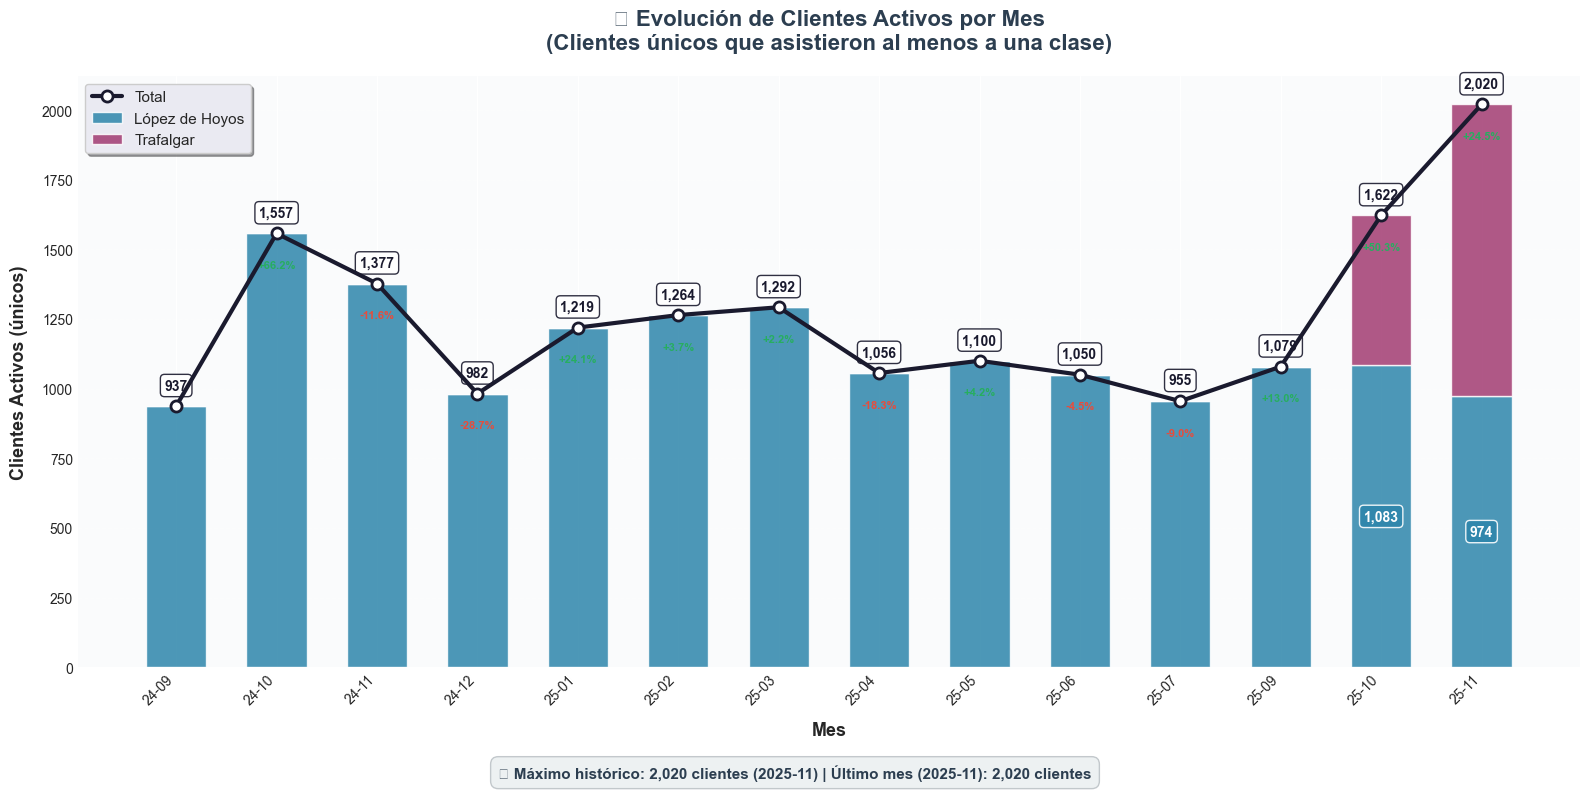


📊 ESTADÍSTICAS DE CLIENTES ACTIVOS:
   Promedio mensual (total): 1,250 clientes
   Máximo: 2,020 clientes (2025-11)
   Mínimo: 937 clientes (2024-09)
   Último mes (2025-11): 2,020 clientes
   Tendencia últimos 3 meses: 📈 Creciente


In [152]:
# =============================================================================
# EVOLUCIÓN DE CLIENTES ACTIVOS POR MES
# Clientes únicos que asistieron al menos a una clase en cada mes
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("📈 EVOLUCIÓN DE CLIENTES ACTIVOS POR MES")
print("="*70)
print("(Clientes únicos que asistieron al menos a una clase en cada mes)\n")

# Calcular clientes únicos por mes y ubicación
clientes_por_mes = df.groupby(['Mes_Nombre', 'Nombre de la Ubicacion'])['ID del Cliente'].nunique().reset_index()
clientes_por_mes.columns = ['Mes', 'Ubicacion', 'Clientes Activos']

# Crear pivot table
pivot_clientes_activos = clientes_por_mes.pivot(index='Mes', columns='Ubicacion', values='Clientes Activos').fillna(0).astype(int)

# Calcular total
pivot_clientes_activos['TOTAL'] = pivot_clientes_activos.sum(axis=1)

# Excluir agosto (estudio cerrado)
pivot_clientes_activos = pivot_clientes_activos[~pivot_clientes_activos.index.str.contains('2024-08|2025-08')]

print("📊 Tabla de Clientes Activos por Mes:")
display(pivot_clientes_activos)

# =============================================================================
# GRÁFICA: Evolución de clientes activos
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 8))

# Colores elegantes
color_lopez = '#2E86AB'  # Azul
color_trafalgar = '#A23B72'  # Magenta
color_total = '#1a1a2e'  # Azul oscuro

meses = pivot_clientes_activos.index.tolist()
x = np.arange(len(meses))

# Obtener datos por ubicación
if 'López de Hoyos - esBarre' in pivot_clientes_activos.columns:
    lopez_data = pivot_clientes_activos['López de Hoyos - esBarre'].values
else:
    lopez_data = np.zeros(len(meses))

if 'Trafalgar - esBarré' in pivot_clientes_activos.columns:
    trafalgar_data = pivot_clientes_activos['Trafalgar - esBarré'].values
else:
    trafalgar_data = np.zeros(len(meses))

total_data = pivot_clientes_activos['TOTAL'].values

# Barras apiladas
width = 0.6
bars_lopez = ax.bar(x, lopez_data, width, label='López de Hoyos', color=color_lopez, alpha=0.85, edgecolor='white', linewidth=1)
bars_trafalgar = ax.bar(x, trafalgar_data, width, bottom=lopez_data, label='Trafalgar', color=color_trafalgar, alpha=0.85, edgecolor='white', linewidth=1)

# Línea de total
ax.plot(x, total_data, color=color_total, linewidth=3, marker='o', markersize=8, 
        label='Total', zorder=5, markerfacecolor='white', markeredgewidth=2)

# Añadir valores en la línea de total
for i, total in enumerate(total_data):
    ax.annotate(f'{int(total):,}', (x[i], total), textcoords="offset points", 
                xytext=(0, 12), ha='center', fontsize=10, fontweight='bold', color=color_total,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color_total, alpha=0.9))

# Añadir valores de López de Hoyos en octubre y noviembre
for i, mes in enumerate(meses):
    if mes in ['2025-10', '2025-11']:
        lopez_val = int(lopez_data[i])
        ax.annotate(f'{lopez_val:,}', (x[i], lopez_data[i] / 2), 
                    ha='center', va='center', fontsize=10, fontweight='bold', color='white',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color_lopez, edgecolor='white', alpha=0.9))

# Calcular y mostrar MoM% para total
for i in range(1, len(total_data)):
    if total_data[i-1] > 0:
        mom_pct = ((total_data[i] - total_data[i-1]) / total_data[i-1]) * 100
        color_mom = '#27ae60' if mom_pct >= 0 else '#e74c3c'
        ax.annotate(f'{mom_pct:+.1f}%', (x[i], total_data[i]), textcoords="offset points", 
                    xytext=(0, -25), ha='center', fontsize=8, fontweight='bold', color=color_mom)

# Estilo del gráfico
ax.set_xlabel('Mes', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Clientes Activos (únicos)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('📈 Evolución de Clientes Activos por Mes\n(Clientes únicos que asistieron al menos a una clase)', 
             fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

# Resumen
max_mes = meses[np.argmax(total_data)]
max_clientes = int(np.max(total_data))
ultimo_mes = meses[-1]
ultimo_clientes = int(total_data[-1])
resumen_text = f'📊 Máximo histórico: {max_clientes:,} clientes ({max_mes}) | Último mes ({ultimo_mes}): {ultimo_clientes:,} clientes'
fig.text(0.5, 0.02, resumen_text, ha='center', fontsize=11, fontweight='bold', 
         color='#2c3e50', bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', 
                                     edgecolor='#bdc3c7', alpha=0.9))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# =============================================================================
# ESTADÍSTICAS ADICIONALES
# =============================================================================
print("\n📊 ESTADÍSTICAS DE CLIENTES ACTIVOS:")
print("="*60)
print(f"   Promedio mensual (total): {int(total_data.mean()):,} clientes")
print(f"   Máximo: {max_clientes:,} clientes ({max_mes})")
print(f"   Mínimo: {int(np.min(total_data)):,} clientes ({meses[np.argmin(total_data)]})")
print(f"   Último mes ({ultimo_mes}): {ultimo_clientes:,} clientes")

# Tendencia
if len(total_data) >= 3:
    ultimos_3_meses = total_data[-3:]
    tendencia = "📈 Creciente" if ultimos_3_meses[-1] > ultimos_3_meses[0] else "📉 Decreciente"
    print(f"   Tendencia últimos 3 meses: {tendencia}")


## 6. 🔄 Balance Mensual: Nuevos Clientes vs Churn (New vs Old)

En esta sección analizamos, para cada mes:
- **Clientes nuevos**: primera vez que visitan esBarre ese mes.
- **Churn total**: clientes cuya **última visita** histórica fue en ese mes y nunca han vuelto después.
- **Churn new**: de ese churn, los que **empezaron y terminaron** en el mismo mes (su primera visita y su última visita son ese mes).
- **Churn old**: clientes que ya venían de meses anteriores y para los que ese mes es su última visita.

Así podemos ver si el negocio está creciendo porque entran más de los que se van y si el problema está más en retención de nuevos o en retención de clientes antiguos.


🔄 BALANCE MENSUAL: NUEVOS vs CHURN (New vs Old)
📅 Último mes con datos: 2025-11

📊 Tabla de balance mensual (Nuevos vs Churn):


,Mes,Clientes Nuevos,Churn New,Churn Old,Churn Total,Balance Neto,Stock Acumulado
0,2024-09,937,436,0,436,501,501
1,2024-10,1167,692,111,803,364,865
2,2024-11,786,484,154,638,148,1013
3,2024-12,401,248,127,375,26,1039
4,2025-01,600,357,146,503,97,1136
5,2025-02,550,346,157,503,47,1183
6,2025-03,565,362,166,528,37,1220
7,2025-04,372,251,141,392,-20,1200
8,2025-05,370,235,193,428,-58,1142
9,2025-06,375,238,172,410,-35,1107


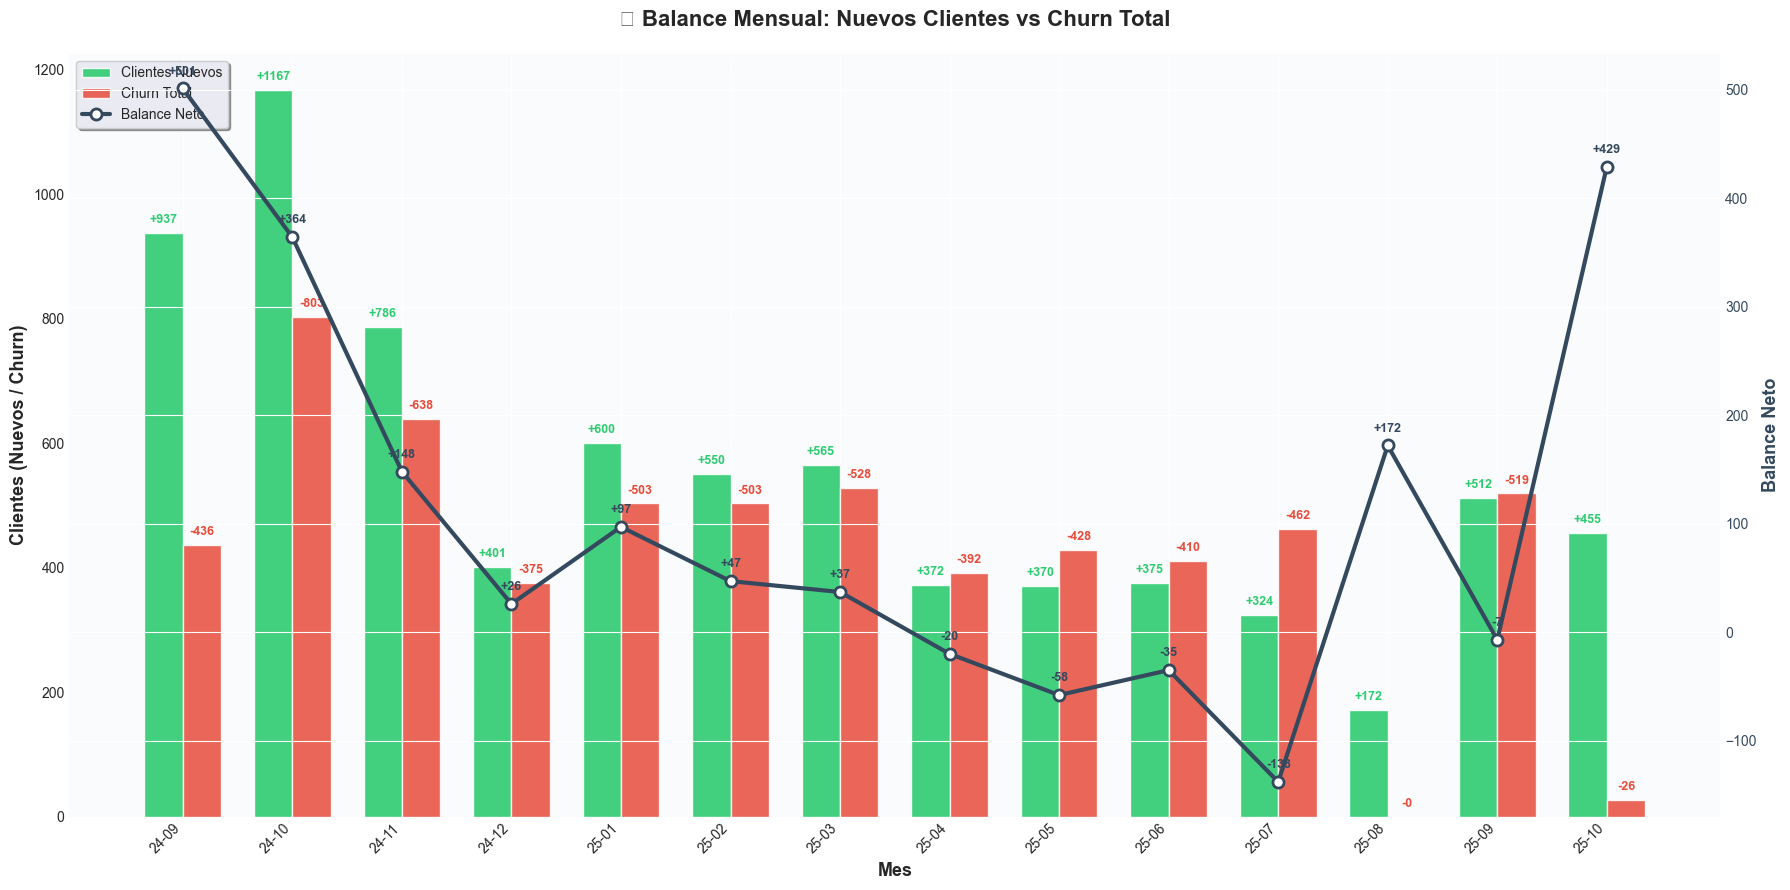

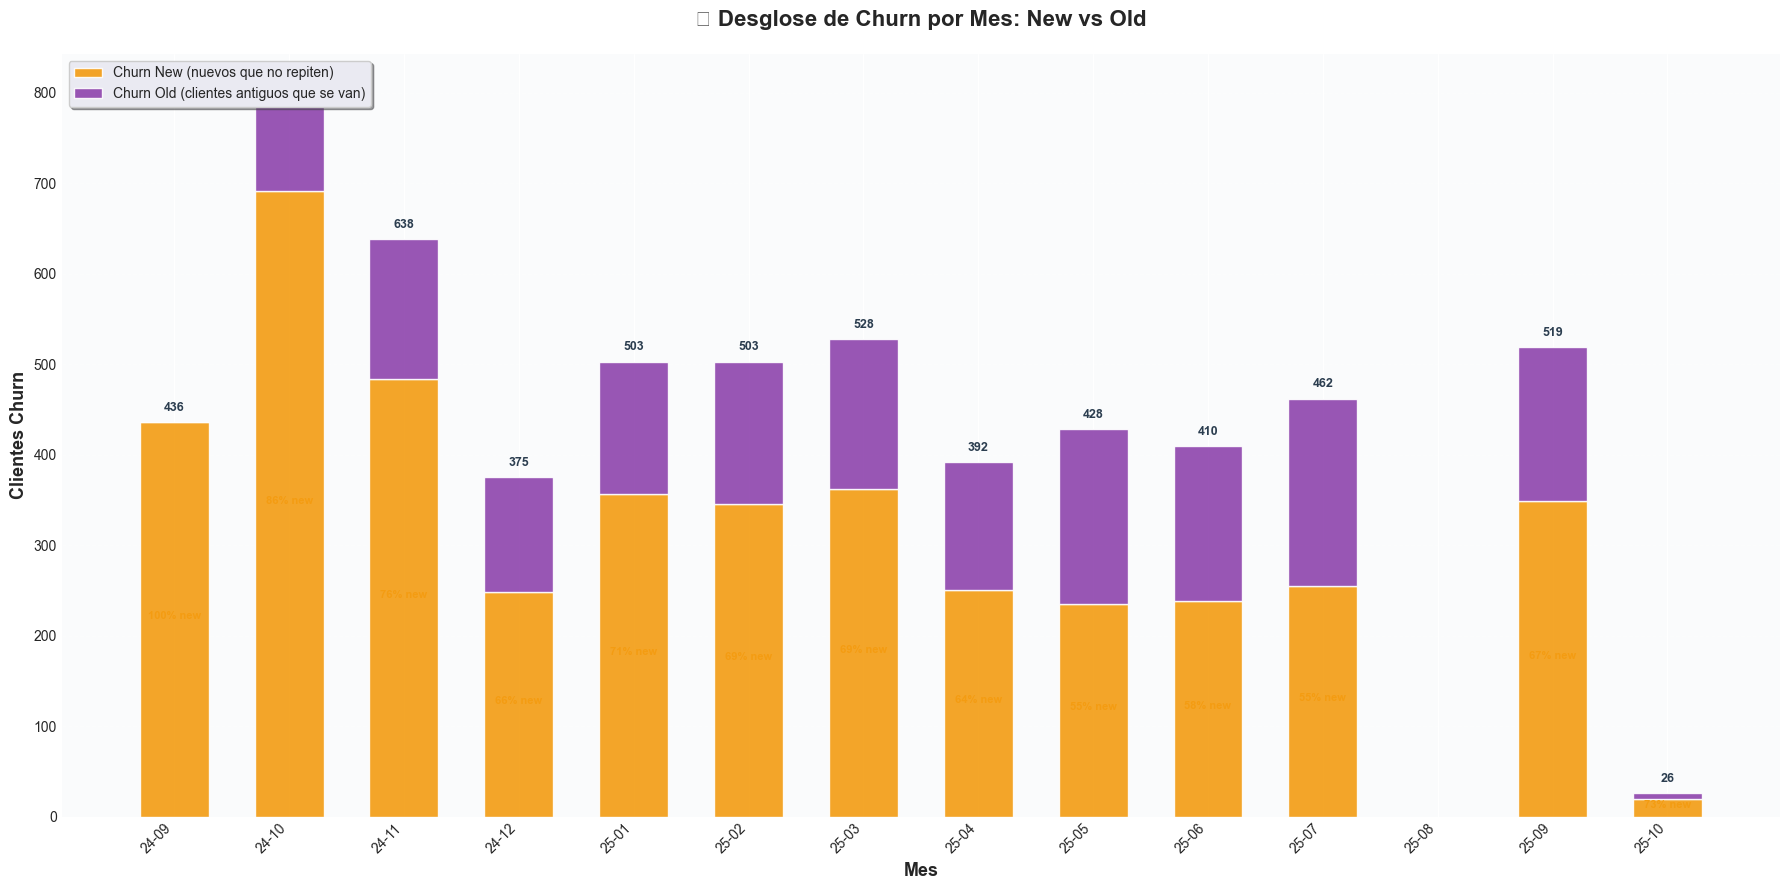


📊 RESUMEN:
   Total clientes nuevos (periodo analizado): 7,586
   Total churn new: 4,272
   Total churn old: 1,751
   Balance neto acumulado: +1,563


In [153]:
# =============================================================================
# BALANCE MENSUAL: NUEVOS CLIENTES vs CHURN (NEW vs OLD)
# =============================================================================

import numpy as np

print("="*70)
print("🔄 BALANCE MENSUAL: NUEVOS vs CHURN (New vs Old)")
print("="*70)

# Asegurarnos de tener columnas de mes para primera y última visita
if 'Mes_Ultima_Visita' not in ultima_visita_cliente.columns:
    ultima_visita_cliente['Mes_Ultima_Visita'] = ultima_visita_cliente['Ultima Visita'].dt.to_period('M')
if 'Mes_Primera_Visita' not in ultima_visita_cliente.columns:
    ultima_visita_cliente['Mes_Primera_Visita'] = ultima_visita_cliente['Primera Visita'].dt.to_period('M')

# Mes máximo disponible en el dataset
mes_maximo = df['Fecha de Visita'].dt.to_period('M').max()
print(f"📅 Último mes con datos: {mes_maximo}")

# -----------------------------------------------------------------------------
# 1. NUEVOS CLIENTES POR MES
# -----------------------------------------------------------------------------

# Usamos la tabla de primera visita creada antes (SOLO LÓPEZ DE HOYOS)
primera_visita_lopez = primera_visita_cliente[primera_visita_cliente['Ubicacion Primera Visita'] == 'López de Hoyos - esBarre'].copy()
primera_visita_lopez['Mes_Primera_Visita'] = primera_visita_lopez['Primera Visita'].dt.to_period('M')

nuevos_mes = (
    primera_visita_lopez
    .groupby('Mes_Primera_Visita')['ID del Cliente']
    .nunique()
    .reset_index(name='Clientes Nuevos')
)

# -----------------------------------------------------------------------------
# 2. CHURN POR MES, SEPARANDO CHURN NEW vs CHURN OLD (DEFINICIÓN 60 DÍAS)
# -----------------------------------------------------------------------------

# Churn "real" para López de Hoyos:
# clientes cuya última visita fue en ese local y llevan al menos 60 días sin venir,
# excluyendo los meses de agosto (estudio cerrado).
UMBRAL_CHURN_DIAS = 60
churn_real = ultima_visita_cliente[
    (ultima_visita_cliente['Ultima Ubicacion'] == 'López de Hoyos - esBarre') &
    (ultima_visita_cliente['Dias_Sin_Visita'] >= UMBRAL_CHURN_DIAS)
].copy()

# Excluir meses de agosto
churn_real = churn_real[~churn_real['Mes_Ultima_Visita'].astype(str).isin(['2024-08', '2025-08'])]

# Definición de tipo de churn
# - Churn New: primera y última visita en el mismo mes
# - Churn Old: primera visita en un mes anterior al de la última visita
churn_real['Tipo_Churn'] = np.where(
    churn_real['Mes_Primera_Visita'] == churn_real['Mes_Ultima_Visita'],
    'Churn New',
    'Churn Old'
)

churn_mes = (
    churn_real
    .groupby(['Mes_Ultima_Visita', 'Tipo_Churn'])['ID del Cliente']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

# Asegurar columnas aunque algún mes no tenga de un tipo
for col in ['Churn New', 'Churn Old']:
    if col not in churn_mes.columns:
        churn_mes[col] = 0

churn_mes['Churn Total'] = churn_mes['Churn New'] + churn_mes['Churn Old']

# -----------------------------------------------------------------------------
# 3. COMBINAR NUEVOS vs CHURN EN UNA SOLA TABLA
# -----------------------------------------------------------------------------

nuevos_mes['Mes'] = nuevos_mes['Mes_Primera_Visita'].astype(str)
churn_mes['Mes'] = churn_mes['Mes_Ultima_Visita'].astype(str)

# Solo meses anteriores al último para comparación justa
nuevos_mes_filtrado = nuevos_mes[nuevos_mes['Mes_Primera_Visita'] < mes_maximo].copy()

balance_mes = (
    nuevos_mes_filtrado[['Mes', 'Clientes Nuevos']]
    .merge(
        churn_mes[['Mes', 'Churn New', 'Churn Old', 'Churn Total']],
        on='Mes', how='outer'
    )
    .fillna(0)
)

# Ordenar por mes cronológicamente
balance_mes['Mes_Periodo'] = balance_mes['Mes'].astype('period[M]')
balance_mes = balance_mes.sort_values('Mes_Periodo').reset_index(drop=True)

# Cast a int
for col in ['Clientes Nuevos', 'Churn New', 'Churn Old', 'Churn Total']:
    balance_mes[col] = balance_mes[col].astype(int)

# Calcular balance neto y stock acumulado
balance_mes['Balance Neto'] = balance_mes['Clientes Nuevos'] - balance_mes['Churn Total']
balance_mes['Stock Acumulado'] = balance_mes['Balance Neto'].cumsum()

print("\n📊 Tabla de balance mensual (Nuevos vs Churn):")
display(balance_mes[['Mes', 'Clientes Nuevos', 'Churn New', 'Churn Old', 'Churn Total', 'Balance Neto', 'Stock Acumulado']])

# -----------------------------------------------------------------------------
# 4. GRÁFICO 1: Nuevos vs Churn Total + Balance Neto
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt

meses = balance_mes['Mes'].tolist()
x = np.arange(len(meses))

fig, ax = plt.subplots(figsize=(18, 9))

color_nuevos = '#2ecc71'   # Verde
color_churn = '#e74c3c'    # Rojo
color_balance = '#34495e'  # Gris azulado

# Barras de nuevos y churn total
width = 0.35
bars_nuevos = ax.bar(x - width/2, balance_mes['Clientes Nuevos'], width,
                     label='Clientes Nuevos', color=color_nuevos, alpha=0.9, edgecolor='white')
bars_churn = ax.bar(x + width/2, balance_mes['Churn Total'], width,
                    label='Churn Total', color=color_churn, alpha=0.85, edgecolor='white')

# Línea de balance neto
ax2 = ax.twinx()
ax2.plot(x, balance_mes['Balance Neto'], color=color_balance, linewidth=3,
         marker='o', markersize=8, label='Balance Neto', markerfacecolor='white', markeredgewidth=2)

# Etiquetas en barras
for bar in bars_nuevos:
    height = bar.get_height()
    ax.annotate(f'+{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom', fontsize=9, fontweight='bold', color=color_nuevos)

for bar in bars_churn:
    height = bar.get_height()
    ax.annotate(f'-{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom', fontsize=9, fontweight='bold', color=color_churn)

# Etiquetas en la línea de balance neto
for i, val in enumerate(balance_mes['Balance Neto']):
    ax2.annotate(f'{int(val):+}', (x[i], val), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=9, fontweight='bold', color=color_balance)

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Clientes (Nuevos / Churn)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Balance Neto', fontsize=13, fontweight='bold', color=color_balance)
ax2.tick_params(axis='y', labelcolor=color_balance)

ax.set_title('🔄 Balance Mensual: Nuevos Clientes vs Churn Total',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')

# Leyenda combinada
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
          frameon=True, fancybox=True, shadow=True)

ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 5. GRÁFICO 2: Desglose de Churn (New vs Old)
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(18, 9))

color_churn_new = '#f39c12'   # Naranja
color_churn_old = '#8e44ad'   # Morado

bottom = np.zeros(len(meses))

bars_churn_new = ax.bar(x, balance_mes['Churn New'], width=0.6,
                        label='Churn New (nuevos que no repiten)',
                        color=color_churn_new, alpha=0.9, edgecolor='white')

bars_churn_old = ax.bar(x, balance_mes['Churn Old'], width=0.6,
                        bottom=balance_mes['Churn New'],
                        label='Churn Old (clientes antiguos que se van)',
                        color=color_churn_old, alpha=0.9, edgecolor='white')

# Etiquetas
for i in range(len(meses)):
    total_mes = balance_mes['Churn Total'].iloc[i]
    if total_mes == 0:
        continue
    new_val = balance_mes['Churn New'].iloc[i]
    old_val = balance_mes['Churn Old'].iloc[i]
    ax.annotate(f'{int(total_mes)}', (x[i], total_mes), textcoords="offset points",
                xytext=(0, 8), ha='center', fontsize=9, fontweight='bold', color='#2c3e50')
    # Porcentaje de churn new
    pct_new = new_val / total_mes * 100 if total_mes > 0 else 0
    ax.annotate(f'{pct_new:.0f}% new', (x[i], new_val / 2), textcoords="offset points",
                xytext=(0, 0), ha='center', fontsize=8, color=color_churn_new, fontweight='bold')

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Clientes Churn', fontsize=13, fontweight='bold')
ax.set_title('📉 Desglose de Churn por Mes: New vs Old', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# Resumen numérico
print("\n📊 RESUMEN:")
print("="*60)
print(f"   Total clientes nuevos (periodo analizado): {balance_mes['Clientes Nuevos'].sum():,}")
print(f"   Total churn new: {balance_mes['Churn New'].sum():,}")
print(f"   Total churn old: {balance_mes['Churn Old'].sum():,}")
# Balance neto acumulado con formato signo + separador de miles
balance_acumulado = balance_mes['Balance Neto'].sum()
print(f"   Balance neto acumulado: {balance_acumulado:+,}")


## 7. 📊 Análisis de Reservas (sin agosto)

En esta sección analizamos las **reservas (visitas)** excluyendo siempre los meses de agosto (estudio cerrado):

- **Evolución de las reservas totales**: mismo estilo que la gráfica de clientes activos (barras por local + línea de total).
- **Evolución de las reservas por persona**: cuántas reservas hace de media cada cliente activo por mes.
- **Evolución de reservas de clientes nuevos vs recurrentes**: stack de reservas de clientes que empiezan ese mes vs los que ya habían reservado antes.
- **Evolución de reservas por `tipo_reserva`**: bonos, clase suelta, Gympass, ClassPass, invitaciones, etc.


In [ ]:
# =============================================================================
# 7. ANÁLISIS DE RESERVAS (EXCLUYENDO AGOSTO)
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt

print("="*70)
print("📊 ANÁLISIS DE RESERVAS (sin agosto)")
print("="*70)

# Filtrar datos excluyendo agosto 2024 y 2025
meses_excluir = ['2024-08', '2025-08']
df_res = df[~df['Mes_Nombre'].isin(meses_excluir)].copy()

# Asegurar columnas de periodo de mes
if 'Mes_Periodo' not in df_res.columns:
    df_res['Mes_Periodo'] = df_res['Fecha de Visita'].dt.to_period('M')

# -----------------------------------------------------------------------------
# 1. EVOLUCIÓN DE LAS RESERVAS TOTALES (POR LOCAL + TOTAL)
# -----------------------------------------------------------------------------

reservas_mes_loc = (
    df_res
    .groupby(['Mes_Nombre', 'Nombre de la Ubicacion'])
    .size()
    .reset_index(name='Reservas')
)

pivot_reservas_loc = reservas_mes_loc.pivot(index='Mes_Nombre',
                                            columns='Nombre de la Ubicacion',
                                            values='Reservas').fillna(0).astype(int)

# Orden cronológico por mes
años_meses_orden = pivot_reservas_loc.index.astype('period[M]').sort_values()
pivot_reservas_loc = pivot_reservas_loc.loc[años_meses_orden.astype(str)]

# Calcular total
pivot_reservas_loc['TOTAL'] = pivot_reservas_loc.sum(axis=1)

print("\n📊 Reservas totales por mes y local (sin agosto):")
display(pivot_reservas_loc)

fig, ax = plt.subplots(figsize=(16, 8))

color_lopez = '#2E86AB'
color_trafalgar = '#A23B72'
color_total = '#1a1a2e'

meses = pivot_reservas_loc.index.tolist()
x = np.arange(len(meses))

lopez_data = pivot_reservas_loc.get('López de Hoyos - esBarre', pd.Series(0, index=meses)).values
trafalgar_data = pivot_reservas_loc.get('Trafalgar - esBarré', pd.Series(0, index=meses)).values
total_data = pivot_reservas_loc['TOTAL'].values

width = 0.6
bars_lopez = ax.bar(x, lopez_data, width, label='López de Hoyos', color=color_lopez,
                    alpha=0.85, edgecolor='white', linewidth=1)
ax.bar(x, trafalgar_data, width, bottom=lopez_data, label='Trafalgar',
       color=color_trafalgar, alpha=0.85, edgecolor='white', linewidth=1)

ax.plot(x, total_data, color=color_total, linewidth=3, marker='o', markersize=8,
        label='Total reservas', zorder=5, markerfacecolor='white', markeredgewidth=2)

for i, total in enumerate(total_data):
    ax.annotate(f'{int(total):,}', (x[i], total), textcoords='offset points',
                xytext=(0, 10), ha='center', fontsize=9, fontweight='bold', color=color_total,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor=color_total, alpha=0.9))

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas (visitas)', fontsize=13, fontweight='bold')
ax.set_title('📊 Evolución de Reservas Totales por Mes (sin agosto)', fontsize=16,
             fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 2. EVOLUCIÓN DE LAS RESERVAS POR PERSONA
# -----------------------------------------------------------------------------

reservas_mes = df_res.groupby('Mes_Nombre').size()
clientes_mes = df_res.groupby('Mes_Nombre')['ID del Cliente'].nunique()

reservas_por_cliente = (reservas_mes / clientes_mes).rename('Reservas por Cliente')
# Ordenar usando los mismos meses que en pivot_reservas_loc (convertimos PeriodIndex -> str)
reservas_por_cliente = reservas_por_cliente.loc[años_meses_orden.astype(str)]

print("\n📊 Reservas por cliente y mes (media):")
display(reservas_por_cliente.to_frame())

# Media acumulada: cada mes es la media de ese mes y todos los anteriores
reservas_media_acumulada = reservas_por_cliente.expanding().mean().rename('Media acumulada')

fig, ax = plt.subplots(figsize=(14, 7))

# Línea de media mensual
ax.plot(reservas_por_cliente.index.tolist(), reservas_por_cliente.values,
        marker='o', linewidth=2, color='#95a5a6', label='Media mensual')

# Línea de media acumulada (mes actual + anteriores)
ax.plot(reservas_media_acumulada.index.tolist(), reservas_media_acumulada.values,
        marker='o', linewidth=3, color='#2c3e50', label='Media acumulada')

# Anotaciones solo en la media acumulada para que el gráfico sea más limpio
for x_tick, val in zip(reservas_media_acumulada.index.tolist(), reservas_media_acumulada.values):
    ax.annotate(f'{val:.2f}', (x_tick, val), textcoords='offset points',
                xytext=(0, 8), ha='center', fontsize=9, fontweight='bold', color='#2c3e50')

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas por cliente (media)', fontsize=13, fontweight='bold')
ax.set_title('📈 Reservas por Cliente Activo\nMedia mensual vs Media acumulada (sin agosto)', fontsize=16,
             fontweight='bold', pad=20)
ax.set_xticks(reservas_por_cliente.index.tolist())
ax.set_xticklabels([m[2:] for m in reservas_por_cliente.index.tolist()], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. EVOLUCIÓN DE RESERVAS: CLIENTES NUEVOS vs RECURRENTES
# -----------------------------------------------------------------------------

# Aseguramos columna de Mes_Primera_Visita en primera_visita_cliente
if 'Mes_Primera_Visita' not in primera_visita_cliente.columns:
    primera_visita_cliente['Mes_Primera_Visita'] = primera_visita_cliente['Primera Visita'].dt.to_period('M')

map_primera_visita = primera_visita_cliente.set_index('ID del Cliente')['Mes_Primera_Visita']

df_res['Mes_Primera_Visita'] = df_res['ID del Cliente'].map(map_primera_visita)
df_res['Segmento_Reserva'] = np.where(
    df_res['Mes_Periodo'] == df_res['Mes_Primera_Visita'],
    'Nuevos',
    'Recurrentes'
)

reservas_segmento = (
    df_res
    .groupby(['Mes_Periodo', 'Segmento_Reserva'])
    .size()
    .unstack(fill_value=0)
)

reservas_segmento = reservas_segmento.loc[años_meses_orden]
reservas_segmento['TOTAL'] = reservas_segmento.sum(axis=1)

print("\n📊 Reservas por segmento (Nuevos vs Recurrentes) y mes:")
display(reservas_segmento)

fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(reservas_segmento.index))
meses_seg = [str(p) for p in reservas_segmento.index]

color_nuevos = '#f39c12'
color_recurrentes = '#3498db'
color_total_seg = '#1a1a2e'

nuevos_data = reservas_segmento['Nuevos'].values
recurrentes_data = reservas_segmento['Recurrentes'].values
total_seg = reservas_segmento['TOTAL'].values

width = 0.6
ax.bar(x, recurrentes_data, width, label='Recurrentes', color=color_recurrentes,
       alpha=0.85, edgecolor='white', linewidth=1)
ax.bar(x, nuevos_data, width, bottom=recurrentes_data, label='Nuevos',
       color=color_nuevos, alpha=0.9, edgecolor='white', linewidth=1)

ax.plot(x, total_seg, color=color_total_seg, linewidth=3, marker='o', markersize=8,
        label='Total reservas', zorder=5, markerfacecolor='white', markeredgewidth=2)

for i, total in enumerate(total_seg):
    ax.annotate(f'{int(total):,}', (x[i], total), textcoords='offset points',
                xytext=(0, 10), ha='center', fontsize=9, fontweight='bold', color=color_total_seg)

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas (visitas)', fontsize=13, fontweight='bold')
ax.set_title('🔄 Evolución de Reservas: Clientes Nuevos vs Recurrentes (sin agosto)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses_seg], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 4. EVOLUCIÓN DE RESERVAS POR TIPO_RESERVA
# -----------------------------------------------------------------------------

reservas_tipo = (
    df_res
    .groupby(['Mes_Periodo', 'tipo_reserva'])
    .size()
    .unstack(fill_value=0)
)

# Ordenar columnas por total descendente
orden_cols = reservas_tipo.sum().sort_values(ascending=False).index
reservas_tipo = reservas_tipo[orden_cols]
reservas_tipo = reservas_tipo.loc[años_meses_orden]

print("\n📊 Reservas por tipo_reserva y mes:")
display(reservas_tipo.astype(int))

fig, ax = plt.subplots(figsize=(18, 9))

colores_area = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6',
                '#1abc9c', '#e67e22', '#34495e']

ax.stackplot(range(len(reservas_tipo.index)),
             [reservas_tipo[col].values for col in reservas_tipo.columns],
             labels=reservas_tipo.columns,
             colors=colores_area[:len(reservas_tipo.columns)],
             alpha=0.85, edgecolor='white', linewidth=0.5)

# Línea de total
totales_tipo = reservas_tipo.sum(axis=1).values
ax.plot(range(len(reservas_tipo.index)), totales_tipo,
        color='#2c3e50', linewidth=3, linestyle='--', marker='o',
        markersize=6, label='Total reservas', zorder=5)

for i, total in enumerate(totales_tipo):
    ax.annotate(f'{int(total):,}', (i, total), textcoords='offset points',
                xytext=(0, 8), ha='center', fontsize=9, fontweight='bold', color='#2c3e50')

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas (visitas)', fontsize=13, fontweight='bold')
ax.set_title('📊 Evolución de Reservas por tipo_reserva (sin agosto)', fontsize=16,
             fontweight='bold', pad=20)
ax.set_xticks(range(len(reservas_tipo.index)))
ax.set_xticklabels([str(p)[2:] for p in reservas_tipo.index], rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True,
          fancybox=True, shadow=True, title='tipo_reserva')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout(rect=[0, 0.02, 0.8, 1])
plt.show()


📊 ANÁLISIS DE RESERVAS (sin agosto)

📊 Reservas totales por mes y local (sin agosto) con MoM% y YoY%:


Nombre de la Ubicacion,López de Hoyos - esBarre,López de Hoyos - esBarre MoM%,López de Hoyos - esBarre YoY%,Trafalgar - esBarré,Trafalgar - esBarré MoM%,TOTAL,TOTAL MoM%
Mes_Nombre,,,,,,,
2024-09,1362,NaN,NaN,0,NaN,1362,NaN
2024-10,3229,137.1,NaN,0,NaN,3229,137.1
2024-11,3098,-4.1,NaN,0,NaN,3098,-4.1
2024-12,2248,-27.4,NaN,0,NaN,2248,-27.4
2025-01,2960,31.7,NaN,0,NaN,2960,31.7
2025-02,3156,6.6,NaN,0,NaN,3156,6.6
2025-03,3529,11.8,NaN,0,NaN,3529,11.8
2025-04,2741,-22.3,NaN,0,NaN,2741,-22.3
2025-05,2921,6.6,NaN,0,NaN,2921,6.6


: 